In [1]:
import numpy as np
import matplotlib.pyplot as plt  # Just so we can visually confirm we have the same images
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.utils#.data.Dataset
import glob
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F

import warnings
warnings.filterwarnings('ignore', '.*output shape of zoom.*')

from random import shuffle

from torch.optim.lr_scheduler import StepLR

from random import shuffle
from numpy import percentile

import random
import cv2

from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
from torchvision import transforms
import torchvision.transforms.functional as TF
gpu_number = "2"            

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_number



In [2]:
i=plt.imread('/home/Drive3/rahul/heart-seg/dataset_train/P0001image.png')

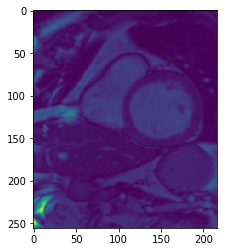

In [3]:
plt.imshow(i); plt.show()

In [4]:
tra=glob.glob('/home/Drive3/rahul/heart-seg/myds/*')
msk_list=glob.glob('/home/Drive3/rahul/heart-seg/myds_mask/*')
len(msk_list)

243

In [5]:
    tra#[10][34:39],len('/home/Drive3/rahul/heart-seg/myds/')

['/home/Drive3/rahul/heart-seg/myds/P0121image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0063image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0007image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0176image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0115image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0166image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0170image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0075image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0042image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0217image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0229image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0241image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0134image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0066image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0004image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0093image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0103image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0162image.png',
 '/home/Drive3/rahul/heart-seg/myds/P0100image

In [6]:
name=tra[10][34:39]
plt.imread('/home/Drive3/rahul/heart-seg/myds_mask/'+name+'mask_gnd.png')
# f=iter(CustomDataset(['P0103']))
# a=next(f)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
im_list=glob.glob('/home/Drive3/rahul/heart-seg/myds/*')
im_list[-48:][0][34:39]

'P0164'

In [8]:

def one_hot(a):
    g1=a[:,:]==0
    g2=a[:,:]==1

    return torch.stack((g1,g2),0)


class heartDataset(Dataset):
    """Heart MRI Dataset dataset."""
    
    def __init__(self,mode,transform=False):

        self.im_list=glob.glob('/home/Drive3/rahul/heart-seg/myds/*')
        self.msk_list=glob.glob('/home/Drive3/rahul/heart-seg/myds_mask/*')
        if mode=='train':
            self.im_list=self.im_list[:-48]
        else:
            self.im_list=self.im_list[-48:]
        self.transform = transform
        
    def __len__(self):
        return len(self.im_list)
    
    def __getitem__(self, idx):
        small_flag = 0
#         if len(self.im_list)<50: print('im',self.im_list[idx])
        image=cv2.imread(self.im_list[idx],0)
        name=self.im_list[idx][34:39]
#         if len(self.im_list)<50: print('name',name)
        mask=plt.imread('/home/Drive3/rahul/heart-seg/myds_mask/'+name+'mask_gnd.png') 
        #image = io.imread(img_name)/255
        #image = io.imread(img_name)*(2/255) - 1
        #image = image - np.mean(image)
        #image = image / (2*np.std(image))
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image = clahe.apply(image)
        image = torch.from_numpy(image).float().unsqueeze(0)
        image = image/255
        
        groundTruth = mask#/255
        groundTruth = torch.from_numpy(groundTruth).float()#.unsqueeze(0)
        label_sum = groundTruth.sum()
        if label_sum < 1500:
            small_flag = 1
\
        if self.transform:
            
            to_pil = transforms.ToPILImage()
            to_ten = transforms.ToTensor()
            if random.random() >0.5:
                image = to_ten(TF.hflip(to_pil(image)))
                groundTruth = to_ten(TF.hflip(to_pil(groundTruth)))
            
            deg = random.randint(-90, 90)
            image = to_ten(TF.rotate(to_pil(image),deg))
            groundTruth = to_ten(TF.rotate(to_pil(groundTruth),deg))

        seg=one_hot(groundTruth) 
        sample = {'image': image, 'mask':seg,'mask2': groundTruth,  'small_flag': small_flag,'name':name }
        return sample

class CustomDataset(Dataset):
    """Heart MRI Dataset dataset."""
    
    def __init__(self,names,transform=False):

        self.im_list=glob.glob('/home/Drive3/rahul/heart-seg/myds/*')
        self.msk_list=glob.glob('/home/Drive3/rahul/heart-seg/myds_mask/*')
        self.transform = transform
        self.names=names
    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        small_flag = 0
        name='/home/Drive3/rahul/heart-seg/myds/'+self.names[idx]+'image.png'
#         prin/t(name)
        
        image=cv2.imread(name,0)
        name=self.names[idx]
#         print(nam/e)
        mask=plt.imread('/home/Drive3/rahul/heart-seg/myds_mask/'+name+'mask_gnd.png') 
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        image = clahe.apply(image)
        image = torch.from_numpy(image).float().unsqueeze(0)
        image = image/255
        groundTruth = mask#/255
        groundTruth = torch.from_numpy(groundTruth).float()#.unsqueeze(0)
        label_sum = groundTruth.sum()
        if label_sum < 1500:
            small_flag = 1

        if self.transform:
            to_pil = transforms.ToPILImage()
            to_ten = transforms.ToTensor()
            if random.random() >0.5:
                image = to_ten(TF.hflip(to_pil(image)))
                groundTruth = to_ten(TF.hflip(to_pil(groundTruth)))
            
            deg = random.randint(-90, 90)
            image = to_ten(TF.rotate(to_pil(image),deg))
            groundTruth = to_ten(TF.rotate(to_pil(groundTruth),deg))

        seg=one_hot(groundTruth) 
       
        #label = torch.cat([(1-groundTruth), groundTruth], dim=0)
        sample = {'image': image, 'mask':seg,'mask2': groundTruth,  'small_flag': small_flag,'name':name }
            
        return sample


In [9]:
ds=heartDataset('train')

In [10]:
a=iter(ds)

In [11]:
d=next(a)
np.unique(d['mask2'])

array([0., 1.], dtype=float32)

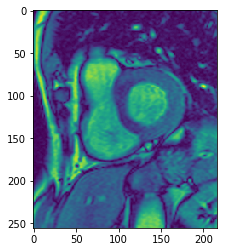

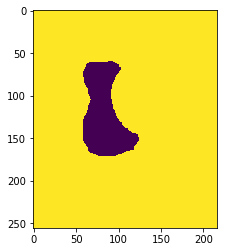

In [12]:
plt.imshow(d['image'][0]);plt.show()
plt.imshow(d['mask'][0]); plt.show()

In [13]:


import torch.nn.functional as F


class double_conv(torch.nn.Module):
    '''(conv => BN => ReLU) * 2'''
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_ch, out_ch, 3, padding=1),
            torch.nn.BatchNorm2d(out_ch),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_ch, out_ch, 3, padding=1),
            torch.nn.BatchNorm2d(out_ch),
            torch.nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = torch.nn.Sequential(
            torch.nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(torch.nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = torch.nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)
        self.conv2=double_conv(1280,out_ch)
        self.up2=torch.nn.ConvTranspose2d(1024, in_ch//2, 2, stride=2)
    def forward(self, x1, x2):
        try:x1 = self.up(x1)
        except: x1 = self.up2(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
#         print(x.size())
        try:x = self.conv(x)
        except: x=self.conv2(x)
        return x


class outconv(torch.nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = torch.nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x

In [14]:
n_classes=2
class UNet(torch.nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.down4hard = down(512, 512)
        
        self.up1 = up(1536, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        xhard=self.down4hard(x4)
        
        
        x = self.up1(torch.cat((x5,xhard),1),x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [15]:
model=UNet(1,2).cuda()
batch_size=8;batch_size_val=8

dataset = heartDataset('train')
dataset_val=heartDataset('val')    #val
data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
val_loader=DataLoader(dataset_val,batch_size_val,shuffle=True, num_workers=2) 
loaders={'train':data_loader,'val': val_loader}

In [16]:
loss_fn = torch.nn.CrossEntropyLoss()  
soft_max=torch.nn.Softmax(dim=1)
init_lr=0.001
opt = torch.optim.Adam(model.parameters(), lr=init_lr)

In [17]:


def dice_loss_classes(inpu, target):  # [bs,4,96,96,64]

    ip=inpu[:,0,:,:].contiguous().view(-1)
    tar=target[:,0,:,:].contiguous().view(-1)
    intersection=(ip * tar).sum() 
    union= ip.sum() + tar.sum()
    score1=1-2*(intersection/union)
    

    ip=inpu[:,1,:,:].contiguous().view(-1)
    tar=target[:,1,:,:].contiguous().view(-1)
    intersection=(ip * tar).sum() 
    union= ip.sum() + tar.sum()
    score2=1-2*(intersection/union)
     
    
    return score1,score2


In [18]:
def loss_to_score(my_dict): # converts dice loss to scores (1-loss)
    for e in my_dict.keys():
        for i in range(len(my_dict[e])):
            my_dict[e][i]=1-my_dict[e][i]
    return(my_dict)


def val_stats(my_dict,threshold=0.8,compare=None):
#     my_dict=loss_to_score(my_dict)
    l=[]
    eps=1
    
    for e in my_dict.keys():
        for i in range(len(my_dict[e])):
            l.append(my_dict[e][i])
#     print(l)       
    print('Global Mean: ', sum(l)/len(l))
    print('Global Std: ', np.std(np.array(l)))
    g=[]
    for e in my_dict.keys():
        for i in range(len(my_dict[e])):
            if my_dict[e][i]>threshold:
                g.append(my_dict[e][i])
    c=0
    for i in range(eps):
        
        print('Epoch: ',i-1, 'with ',c,'below')
        c=0
        for e in my_dict.keys():
            if my_dict[e][i]<=threshold:
                c+=1
            
    clip={}
    counter=0
    for e in my_dict.keys():
        for i in range(len(my_dict[e])):
            if my_dict[e][i]<=threshold:
                counter+=1
                
                if e not in clip.keys():clip[e]=[my_dict[e][i]]
                else:clip[e].append(my_dict[e][i])
            
    try:print('Clipped Mean: ', sum(g)/len(g))
    except: pass
    print('Number clipped: ', counter, 'of total ', len(my_dict.keys()))
    
    print('Suspects: ')
    
    suspect_dict={}
    for e in clip.keys():
        suspect_dict[e]=my_dict[e]
        print(e,clip[e])
        
    data=np.array(l)
    quartiles = percentile(data, [25, 50, 75])
    # calculate min/max
    data_min, data_max = data.min(), data.max()
    # print 5-number summary
    print('--')
    print('--')
    print('Min: %.3f' % data_min)
    print('Q1: %.3f' % quartiles[0])
    print('Median: %.3f' % quartiles[1])
    print('Q3: %.3f' % quartiles[2])
    print('Max: %.3f' % data_max)
    
#     plt.plot(sorted(l))
#     plt.show()
    plt.hist(l)#,bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]*0.05)
    plt.title("histogram") 
    plt.show()
    
    if compare:
        print('Deltas')
        for e in my_dict.keys():
            print(e,' : ', sum(compare[e])/len(compare[e])-sum(my_dict[e]/len(my_dict[e])))
    return(suspect_dict)
    
def tta(my_dict):
    tta=[]
    for e in my_dict.keys():
        print(e,': ', sum(my_dict[e])/len(my_dict[e]), min(my_dict[e]), max(my_dict[e]))
        tta.append(sum(my_dict[e])/len(my_dict[e]))
    print('--')
    
    print('TTA Avg: ',sum(tta)/len(tta))    
    
def make_a(my_dict): # makes a dict on only class 0 dice scores from dict with [class 0, class 1]
    dicta={}
    for e in my_dict.keys():
        dicta[e]=[my_dict[e][0]][0] # takes first elemtn !
    return(dicta)
def make_b(my_dict):# makes a dict on only class 1 dice scores 
    dicta={}
    for e in my_dict.keys():
        dicta[e]=[my_dict[e][1]][0]
    return(dicta)       
        
def diff_checker(big1,big2):
    # Takes in hotlist and biglist of two trains
    # gets all culprits in both sets and returns a comparsion of those
    # biglist needed as some items only in one hotlist

    suspect_dict={}
    for e in big1.keys():
            s1=big1[e][1][0]
            s2=big2[e][1][0]
            diff=s1-s2
            print(e,' : ', diff) # avg across all vals(in case of TTA)
            suspect_dict[e]=[s1,s2,diff]
    return(suspect_dict)

def diff_checker2(big1,big2):
    # Takes in   biglist of single dice vals

    suspect_dict={}
    for e in big1.keys():
            s1=big1[e][0]
            s2=big2[e][0]
            diff=s1-s2
            print(e,' : ', diff) # avg across all vals(in case of TTA)
            suspect_dict[e]=[s1,s2,diff]
    return(suspect_dict)
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n   

# Baseline Train

In [19]:

model=UNet(1,2).cuda()
batch_size=8;batch_size_val=8


for param in model.down4hard.parameters(): # freeze
    param.requires_grad = False

    
    
dataset = heartDataset('train')
dataset_val=heartDataset('val')    #val
data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
val_loader=DataLoader(dataset_val,batch_size_val,shuffle=True, num_workers=2) 
loaders={'train':data_loader,'val': val_loader}

In [20]:
loss_fn = torch.nn.CrossEntropyLoss()  
soft_max=torch.nn.Softmax(dim=1)
init_lr=0.001


opt = torch.optim.Adam(model.parameters(), lr=init_lr)

In [21]:
def trainer(model,epochs,loaders=None,opt=opt):
    global my_dict,my_dict_val,L,Lc,Ldc,L_r,Lv,Lvc,Lvdc
    
    if loaders==None:
        data_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2)
        val_loader=DataLoader(dataset_val,batch_size_val,shuffle=True, num_workers=2) 
        loaders={'train':data_loader,'val': val_loader}
    
    for epoch in range(epochs):
        for e in loaders:
            if e=='train':  model.train() ; grad=True  
            else: model.eval() ; grad=False


            with torch.set_grad_enabled(grad):    
                for idx, batch_data in enumerate(loaders[e]):

                    name=batch_data['name']
                    input = Variable(batch_data['image'].float()).cuda()
                    dice_mask = Variable(batch_data['mask'].float()).cuda()
                    ce_tar=Variable(batch_data['mask2']).cuda()

                    pred_mask = model(input)

                    ce = loss_fn(pred_mask, ce_tar.long())
                    soft_mask=soft_max(pred_mask)

                    a,b=dice_loss_classes(soft_mask, dice_mask)

                    loss = ce+(a+b)/2  
                    if e=='train':
                        for names in name:
                            if names not in my_dict.keys(): my_dict[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict[names][0].append(1-a.item()); my_dict[names][1].append(1-b.item())
                        Lc=np.concatenate((np.array([ce.item()]), Lc)); cross_moving_avg=np.mean(Lc)
                        Ldc=np.concatenate((np.array([b.item()]), Ldc)); dice1=np.mean(Ldc)
                        L_r=np.concatenate((np.array([a.item()]), L_r)); dice0=np.mean(L_r)

                        L=np.concatenate((np.array([loss.item()]), L)); loss_moving_avg=np.mean(L)

                        print('Epoch: ', epoch+1, ' Batch: ',idx+1,' Dice0: ', round(dice0,3),' Dice1: ', round(dice1,3), ' CE: ',round(cross_moving_avg,3),' Loss :' ,round(loss_moving_avg,3))
                        loss.backward()
                        opt.step()
                        opt.zero_grad()
                    else:
                        for names in name:
                            if names not in my_dict_val.keys(): my_dict_val[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict_val[names][0].append(1-a.item()); my_dict_val[names][1].append(1-b.item())
                        print('Val Dice0', round(a.item(),3),' Dice1: ', round(b.item(),3), ' CE: ',round(ce.item(),3),' Loss :' ,round(loss_moving_avg,6) )
                        Lv=np.concatenate((np.array([loss.item()]), Lv)) ; lv_avg=np.mean(Lv)
                        Lvc=np.concatenate((np.array([ce.item()]), Lvc)) ;lvc_avg=np.mean(Lvc)
                        Lvdc=np.concatenate((np.array([b.item()]), Lvdc))
def valider(model,loaders_eval=None,opt=opt):
    if loaders_eval==None:
        data_eval = DataLoader(dataset, 1, shuffle=True, num_workers=2)
        val_eval=DataLoader(dataset_val,1,shuffle=True, num_workers=2) 
        loaders_eval={'train':data_eval,'val': val_eval}
    epochs=1
    global my_dict,my_dict_val,L,Lc,Ldc,L_r,Lv,Lvc,Lvdc
    for epoch in range(epochs):
        for e in loaders_eval:
            if e=='train':  model.train() ; grad=True  
            else: model.eval() ; grad=False


            with torch.set_grad_enabled(grad):    
                for idx, batch_data in enumerate(loaders_eval[e]):

                    name=batch_data['name']
                    input = Variable(batch_data['image'].float()).cuda()#.to(device)
                    dice_mask = Variable(batch_data['mask'].float()).cuda()
                    ce_tar=Variable(batch_data['mask2']).cuda()

                    pred_mask = model(input)

                    ce = loss_fn(pred_mask, ce_tar.long())
                    soft_mask=soft_max(pred_mask)
                    
                    a,b=dice_loss_classes(soft_mask, dice_mask)
                    loss = ce+(a+b)/2  
                    if e=='train':
                        for names in name:
                            if names not in my_dict.keys(): my_dict[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict[names][0].append(1-a.item()); my_dict[names][1].append(1-b.item())
                        Lc=np.concatenate((np.array([ce.item()]), Lc)); cross_moving_avg=np.mean(Lc)
                        Ldc=np.concatenate((np.array([b.item()]), Ldc)); dice1=np.mean(Ldc)
                        L_r=np.concatenate((np.array([a.item()]), L_r)); dice0=np.mean(L_r)

                        L=np.concatenate((np.array([loss.item()]), L)); loss_moving_avg=np.mean(L)

                        print('Epoch: ', epoch+1, ' Batch: ',idx+1,' Dice0: ', round(dice0,3),' Dice1: ', round(dice1,3), ' CE: ',round(cross_moving_avg,3),' Loss :' ,round(loss_moving_avg,3))
    #                     loss.backward()
    #                     opt.step()
                        opt.zero_grad()
                    else:
                        for names in name:
                            if names not in my_dict_val.keys(): my_dict_val[names]=[[1-a.item()],[1-b.item()]]
                            else: my_dict_val[names][0].append(1-a.item()); my_dict_val[names][1].append(1-b.item())
                        print('Val Dice0', round(a.item(),3),' Dice1: ', round(b.item(),3), ' CE: ',round(ce.item(),3),' Loss :' ,round(loss_moving_avg,6) )
                        Lv=np.concatenate((np.array([loss.item()]), Lv)) ; lv_avg=np.mean(Lv)
                        Lvc=np.concatenate((np.array([ce.item()]), Lvc)) ;lvc_avg=np.mean(Lvc)
                        Lvdc=np.concatenate((np.array([b.item()]), Lvdc))


In [24]:
my_dict={}
my_dict_val={}

L=np.array([]);Lc=np.array([]);Ld=np.array([]);Lv=np.array([]);Lvd=np.array([]);Lvc=np.array([]);L_r=np.array([]);Ldc=np.array([]);Lvdc=np.array([])


In [102]:


trainer(model,300)

('Epoch: ', 1, ' Batch: ', 1, ' Dice0: ', 0.355, ' Dice1: ', 0.916, ' CE: ', 0.727, ' Loss :', 1.362)
('Epoch: ', 1, ' Batch: ', 2, ' Dice0: ', 0.342, ' Dice1: ', 0.889, ' CE: ', 0.703, ' Loss :', 1.318)
('Epoch: ', 1, ' Batch: ', 3, ' Dice0: ', 0.328, ' Dice1: ', 0.879, ' CE: ', 0.68, ' Loss :', 1.283)
('Epoch: ', 1, ' Batch: ', 4, ' Dice0: ', 0.317, ' Dice1: ', 0.856, ' CE: ', 0.656, ' Loss :', 1.242)
('Epoch: ', 1, ' Batch: ', 5, ' Dice0: ', 0.307, ' Dice1: ', 0.861, ' CE: ', 0.643, ' Loss :', 1.227)
('Epoch: ', 1, ' Batch: ', 6, ' Dice0: ', 0.299, ' Dice1: ', 0.862, ' CE: ', 0.627, ' Loss :', 1.208)
('Epoch: ', 1, ' Batch: ', 7, ' Dice0: ', 0.292, ' Dice1: ', 0.866, ' CE: ', 0.613, ' Loss :', 1.192)
('Epoch: ', 1, ' Batch: ', 8, ' Dice0: ', 0.286, ' Dice1: ', 0.861, ' CE: ', 0.597, ' Loss :', 1.171)
('Epoch: ', 1, ' Batch: ', 9, ' Dice0: ', 0.28, ' Dice1: ', 0.866, ' CE: ', 0.583, ' Loss :', 1.156)
('Epoch: ', 1, ' Batch: ', 10, ' Dice0: ', 0.274, ' Dice1: ', 0.865, ' CE: ', 0.571,

('Epoch: ', 3, ' Batch: ', 23, ' Dice0: ', 0.131, ' Dice1: ', 0.731, ' CE: ', 0.278, ' Loss :', 0.709)
('Epoch: ', 3, ' Batch: ', 24, ' Dice0: ', 0.13, ' Dice1: ', 0.727, ' CE: ', 0.275, ' Loss :', 0.704)
('Epoch: ', 3, ' Batch: ', 25, ' Dice0: ', 0.129, ' Dice1: ', 0.723, ' CE: ', 0.273, ' Loss :', 0.699)
('Val Dice0', 0.071, ' Dice1: ', 0.609, ' CE: ', 0.269, ' Loss :', 0.699138)
('Val Dice0', 0.063, ' Dice1: ', 0.534, ' CE: ', 0.214, ' Loss :', 0.699138)
('Val Dice0', 0.068, ' Dice1: ', 0.56, ' CE: ', 0.238, ' Loss :', 0.699138)
('Val Dice0', 0.064, ' Dice1: ', 0.652, ' CE: ', 0.221, ' Loss :', 0.699138)
('Val Dice0', 0.068, ' Dice1: ', 0.581, ' CE: ', 0.225, ' Loss :', 0.699138)
('Val Dice0', 0.063, ' Dice1: ', 0.752, ' CE: ', 0.216, ' Loss :', 0.699138)
('Epoch: ', 4, ' Batch: ', 1, ' Dice0: ', 0.128, ' Dice1: ', 0.72, ' CE: ', 0.271, ' Loss :', 0.695)
('Epoch: ', 4, ' Batch: ', 2, ' Dice0: ', 0.127, ' Dice1: ', 0.717, ' CE: ', 0.268, ' Loss :', 0.69)
('Epoch: ', 4, ' Batch: ', 3,

('Epoch: ', 6, ' Batch: ', 15, ' Dice0: ', 0.08, ' Dice1: ', 0.548, ' CE: ', 0.176, ' Loss :', 0.49)
('Epoch: ', 6, ' Batch: ', 16, ' Dice0: ', 0.079, ' Dice1: ', 0.545, ' CE: ', 0.175, ' Loss :', 0.488)
('Epoch: ', 6, ' Batch: ', 17, ' Dice0: ', 0.079, ' Dice1: ', 0.543, ' CE: ', 0.174, ' Loss :', 0.485)
('Epoch: ', 6, ' Batch: ', 18, ' Dice0: ', 0.078, ' Dice1: ', 0.541, ' CE: ', 0.174, ' Loss :', 0.483)
('Epoch: ', 6, ' Batch: ', 19, ' Dice0: ', 0.078, ' Dice1: ', 0.538, ' CE: ', 0.173, ' Loss :', 0.481)
('Epoch: ', 6, ' Batch: ', 20, ' Dice0: ', 0.077, ' Dice1: ', 0.537, ' CE: ', 0.172, ' Loss :', 0.479)
('Epoch: ', 6, ' Batch: ', 21, ' Dice0: ', 0.077, ' Dice1: ', 0.534, ' CE: ', 0.171, ' Loss :', 0.477)
('Epoch: ', 6, ' Batch: ', 22, ' Dice0: ', 0.077, ' Dice1: ', 0.532, ' CE: ', 0.17, ' Loss :', 0.474)
('Epoch: ', 6, ' Batch: ', 23, ' Dice0: ', 0.076, ' Dice1: ', 0.53, ' CE: ', 0.169, ' Loss :', 0.472)
('Epoch: ', 6, ' Batch: ', 24, ' Dice0: ', 0.076, ' Dice1: ', 0.529, ' CE: ',

('Epoch: ', 9, ' Batch: ', 8, ' Dice0: ', 0.057, ' Dice1: ', 0.429, ' CE: ', 0.131, ' Loss :', 0.374)
('Epoch: ', 9, ' Batch: ', 9, ' Dice0: ', 0.057, ' Dice1: ', 0.428, ' CE: ', 0.131, ' Loss :', 0.373)
('Epoch: ', 9, ' Batch: ', 10, ' Dice0: ', 0.056, ' Dice1: ', 0.426, ' CE: ', 0.13, ' Loss :', 0.372)
('Epoch: ', 9, ' Batch: ', 11, ' Dice0: ', 0.056, ' Dice1: ', 0.425, ' CE: ', 0.13, ' Loss :', 0.37)
('Epoch: ', 9, ' Batch: ', 12, ' Dice0: ', 0.056, ' Dice1: ', 0.424, ' CE: ', 0.129, ' Loss :', 0.369)
('Epoch: ', 9, ' Batch: ', 13, ' Dice0: ', 0.056, ' Dice1: ', 0.423, ' CE: ', 0.129, ' Loss :', 0.368)
('Epoch: ', 9, ' Batch: ', 14, ' Dice0: ', 0.055, ' Dice1: ', 0.421, ' CE: ', 0.128, ' Loss :', 0.367)
('Epoch: ', 9, ' Batch: ', 15, ' Dice0: ', 0.055, ' Dice1: ', 0.42, ' CE: ', 0.128, ' Loss :', 0.365)
('Epoch: ', 9, ' Batch: ', 16, ' Dice0: ', 0.055, ' Dice1: ', 0.419, ' CE: ', 0.127, ' Loss :', 0.364)
('Epoch: ', 9, ' Batch: ', 17, ' Dice0: ', 0.055, ' Dice1: ', 0.418, ' CE: ', 0

('Val Dice0', 0.007, ' Dice1: ', 0.145, ' CE: ', 0.037, ' Loss :', 0.306465)
('Val Dice0', 0.007, ' Dice1: ', 0.12, ' CE: ', 0.04, ' Loss :', 0.306465)
('Epoch: ', 12, ' Batch: ', 1, ' Dice0: ', 0.044, ' Dice1: ', 0.355, ' CE: ', 0.106, ' Loss :', 0.306)
('Epoch: ', 12, ' Batch: ', 2, ' Dice0: ', 0.044, ' Dice1: ', 0.354, ' CE: ', 0.105, ' Loss :', 0.305)
('Epoch: ', 12, ' Batch: ', 3, ' Dice0: ', 0.044, ' Dice1: ', 0.354, ' CE: ', 0.105, ' Loss :', 0.304)
('Epoch: ', 12, ' Batch: ', 4, ' Dice0: ', 0.044, ' Dice1: ', 0.353, ' CE: ', 0.105, ' Loss :', 0.303)
('Epoch: ', 12, ' Batch: ', 5, ' Dice0: ', 0.044, ' Dice1: ', 0.352, ' CE: ', 0.105, ' Loss :', 0.302)
('Epoch: ', 12, ' Batch: ', 6, ' Dice0: ', 0.044, ' Dice1: ', 0.351, ' CE: ', 0.104, ' Loss :', 0.302)
('Epoch: ', 12, ' Batch: ', 7, ' Dice0: ', 0.044, ' Dice1: ', 0.35, ' CE: ', 0.104, ' Loss :', 0.301)
('Epoch: ', 12, ' Batch: ', 8, ' Dice0: ', 0.044, ' Dice1: ', 0.349, ' CE: ', 0.104, ' Loss :', 0.3)
('Epoch: ', 12, ' Batch: ',

('Epoch: ', 14, ' Batch: ', 21, ' Dice0: ', 0.037, ' Dice1: ', 0.305, ' CE: ', 0.089, ' Loss :', 0.26)
('Epoch: ', 14, ' Batch: ', 22, ' Dice0: ', 0.036, ' Dice1: ', 0.305, ' CE: ', 0.089, ' Loss :', 0.26)
('Epoch: ', 14, ' Batch: ', 23, ' Dice0: ', 0.036, ' Dice1: ', 0.304, ' CE: ', 0.089, ' Loss :', 0.259)
('Epoch: ', 14, ' Batch: ', 24, ' Dice0: ', 0.036, ' Dice1: ', 0.304, ' CE: ', 0.089, ' Loss :', 0.259)
('Epoch: ', 14, ' Batch: ', 25, ' Dice0: ', 0.036, ' Dice1: ', 0.303, ' CE: ', 0.089, ' Loss :', 0.258)
('Val Dice0', 0.006, ' Dice1: ', 0.097, ' CE: ', 0.035, ' Loss :', 0.258203)
('Val Dice0', 0.004, ' Dice1: ', 0.155, ' CE: ', 0.019, ' Loss :', 0.258203)
('Val Dice0', 0.005, ' Dice1: ', 0.11, ' CE: ', 0.027, ' Loss :', 0.258203)
('Val Dice0', 0.004, ' Dice1: ', 0.136, ' CE: ', 0.02, ' Loss :', 0.258203)
('Val Dice0', 0.005, ' Dice1: ', 0.096, ' CE: ', 0.024, ' Loss :', 0.258203)
('Val Dice0', 0.005, ' Dice1: ', 0.117, ' CE: ', 0.024, ' Loss :', 0.258203)
('Epoch: ', 15, ' Batc

('Epoch: ', 17, ' Batch: ', 12, ' Dice0: ', 0.031, ' Dice1: ', 0.27, ' CE: ', 0.078, ' Loss :', 0.229)
('Epoch: ', 17, ' Batch: ', 13, ' Dice0: ', 0.031, ' Dice1: ', 0.269, ' CE: ', 0.078, ' Loss :', 0.228)
('Epoch: ', 17, ' Batch: ', 14, ' Dice0: ', 0.031, ' Dice1: ', 0.269, ' CE: ', 0.078, ' Loss :', 0.228)
('Epoch: ', 17, ' Batch: ', 15, ' Dice0: ', 0.031, ' Dice1: ', 0.269, ' CE: ', 0.078, ' Loss :', 0.228)
('Epoch: ', 17, ' Batch: ', 16, ' Dice0: ', 0.031, ' Dice1: ', 0.268, ' CE: ', 0.078, ' Loss :', 0.227)
('Epoch: ', 17, ' Batch: ', 17, ' Dice0: ', 0.031, ' Dice1: ', 0.268, ' CE: ', 0.077, ' Loss :', 0.227)
('Epoch: ', 17, ' Batch: ', 18, ' Dice0: ', 0.031, ' Dice1: ', 0.267, ' CE: ', 0.077, ' Loss :', 0.226)
('Epoch: ', 17, ' Batch: ', 19, ' Dice0: ', 0.031, ' Dice1: ', 0.267, ' CE: ', 0.077, ' Loss :', 0.226)
('Epoch: ', 17, ' Batch: ', 20, ' Dice0: ', 0.031, ' Dice1: ', 0.266, ' CE: ', 0.077, ' Loss :', 0.226)
('Epoch: ', 17, ' Batch: ', 21, ' Dice0: ', 0.031, ' Dice1: ', 0.

('Epoch: ', 20, ' Batch: ', 5, ' Dice0: ', 0.027, ' Dice1: ', 0.242, ' CE: ', 0.069, ' Loss :', 0.204)
('Epoch: ', 20, ' Batch: ', 6, ' Dice0: ', 0.027, ' Dice1: ', 0.242, ' CE: ', 0.069, ' Loss :', 0.204)
('Epoch: ', 20, ' Batch: ', 7, ' Dice0: ', 0.027, ' Dice1: ', 0.241, ' CE: ', 0.069, ' Loss :', 0.204)
('Epoch: ', 20, ' Batch: ', 8, ' Dice0: ', 0.027, ' Dice1: ', 0.241, ' CE: ', 0.069, ' Loss :', 0.203)
('Epoch: ', 20, ' Batch: ', 9, ' Dice0: ', 0.027, ' Dice1: ', 0.241, ' CE: ', 0.069, ' Loss :', 0.203)
('Epoch: ', 20, ' Batch: ', 10, ' Dice0: ', 0.027, ' Dice1: ', 0.24, ' CE: ', 0.069, ' Loss :', 0.203)
('Epoch: ', 20, ' Batch: ', 11, ' Dice0: ', 0.027, ' Dice1: ', 0.24, ' CE: ', 0.069, ' Loss :', 0.202)
('Epoch: ', 20, ' Batch: ', 12, ' Dice0: ', 0.027, ' Dice1: ', 0.24, ' CE: ', 0.069, ' Loss :', 0.202)
('Epoch: ', 20, ' Batch: ', 13, ' Dice0: ', 0.027, ' Dice1: ', 0.239, ' CE: ', 0.069, ' Loss :', 0.202)
('Epoch: ', 20, ' Batch: ', 14, ' Dice0: ', 0.027, ' Dice1: ', 0.239, ' 

('Val Dice0', 0.004, ' Dice1: ', 0.092, ' CE: ', 0.023, ' Loss :', 0.185045)
('Val Dice0', 0.004, ' Dice1: ', 0.086, ' CE: ', 0.025, ' Loss :', 0.185045)
('Val Dice0', 0.004, ' Dice1: ', 0.073, ' CE: ', 0.019, ' Loss :', 0.185045)
('Val Dice0', 0.004, ' Dice1: ', 0.182, ' CE: ', 0.021, ' Loss :', 0.185045)
('Val Dice0', 0.006, ' Dice1: ', 0.105, ' CE: ', 0.031, ' Loss :', 0.185045)
('Val Dice0', 0.005, ' Dice1: ', 0.137, ' CE: ', 0.028, ' Loss :', 0.185045)
('Epoch: ', 23, ' Batch: ', 1, ' Dice0: ', 0.024, ' Dice1: ', 0.22, ' CE: ', 0.063, ' Loss :', 0.185)
('Epoch: ', 23, ' Batch: ', 2, ' Dice0: ', 0.024, ' Dice1: ', 0.22, ' CE: ', 0.063, ' Loss :', 0.185)
('Epoch: ', 23, ' Batch: ', 3, ' Dice0: ', 0.024, ' Dice1: ', 0.219, ' CE: ', 0.062, ' Loss :', 0.184)
('Epoch: ', 23, ' Batch: ', 4, ' Dice0: ', 0.024, ' Dice1: ', 0.219, ' CE: ', 0.062, ' Loss :', 0.184)
('Epoch: ', 23, ' Batch: ', 5, ' Dice0: ', 0.024, ' Dice1: ', 0.219, ' CE: ', 0.062, ' Loss :', 0.184)
('Epoch: ', 23, ' Batch: 

('Epoch: ', 25, ' Batch: ', 18, ' Dice0: ', 0.022, ' Dice1: ', 0.203, ' CE: ', 0.057, ' Loss :', 0.17)
('Epoch: ', 25, ' Batch: ', 19, ' Dice0: ', 0.022, ' Dice1: ', 0.203, ' CE: ', 0.057, ' Loss :', 0.17)
('Epoch: ', 25, ' Batch: ', 20, ' Dice0: ', 0.022, ' Dice1: ', 0.202, ' CE: ', 0.057, ' Loss :', 0.169)
('Epoch: ', 25, ' Batch: ', 21, ' Dice0: ', 0.022, ' Dice1: ', 0.202, ' CE: ', 0.057, ' Loss :', 0.169)
('Epoch: ', 25, ' Batch: ', 22, ' Dice0: ', 0.022, ' Dice1: ', 0.202, ' CE: ', 0.057, ' Loss :', 0.169)
('Epoch: ', 25, ' Batch: ', 23, ' Dice0: ', 0.022, ' Dice1: ', 0.202, ' CE: ', 0.057, ' Loss :', 0.169)
('Epoch: ', 25, ' Batch: ', 24, ' Dice0: ', 0.022, ' Dice1: ', 0.201, ' CE: ', 0.057, ' Loss :', 0.169)
('Epoch: ', 25, ' Batch: ', 25, ' Dice0: ', 0.022, ' Dice1: ', 0.201, ' CE: ', 0.057, ' Loss :', 0.169)
('Val Dice0', 0.004, ' Dice1: ', 0.124, ' CE: ', 0.024, ' Loss :', 0.16853)
('Val Dice0', 0.003, ' Dice1: ', 0.061, ' CE: ', 0.016, ' Loss :', 0.16853)
('Val Dice0', 0.00

('Epoch: ', 28, ' Batch: ', 10, ' Dice0: ', 0.02, ' Dice1: ', 0.189, ' CE: ', 0.053, ' Loss :', 0.158)
('Epoch: ', 28, ' Batch: ', 11, ' Dice0: ', 0.02, ' Dice1: ', 0.189, ' CE: ', 0.053, ' Loss :', 0.158)
('Epoch: ', 28, ' Batch: ', 12, ' Dice0: ', 0.02, ' Dice1: ', 0.189, ' CE: ', 0.053, ' Loss :', 0.158)
('Epoch: ', 28, ' Batch: ', 13, ' Dice0: ', 0.02, ' Dice1: ', 0.189, ' CE: ', 0.053, ' Loss :', 0.157)
('Epoch: ', 28, ' Batch: ', 14, ' Dice0: ', 0.02, ' Dice1: ', 0.188, ' CE: ', 0.053, ' Loss :', 0.157)
('Epoch: ', 28, ' Batch: ', 15, ' Dice0: ', 0.02, ' Dice1: ', 0.188, ' CE: ', 0.053, ' Loss :', 0.157)
('Epoch: ', 28, ' Batch: ', 16, ' Dice0: ', 0.02, ' Dice1: ', 0.188, ' CE: ', 0.053, ' Loss :', 0.157)
('Epoch: ', 28, ' Batch: ', 17, ' Dice0: ', 0.02, ' Dice1: ', 0.188, ' CE: ', 0.053, ' Loss :', 0.157)
('Epoch: ', 28, ' Batch: ', 18, ' Dice0: ', 0.02, ' Dice1: ', 0.188, ' CE: ', 0.053, ' Loss :', 0.157)
('Epoch: ', 28, ' Batch: ', 19, ' Dice0: ', 0.02, ' Dice1: ', 0.188, ' CE

('Epoch: ', 31, ' Batch: ', 3, ' Dice0: ', 0.019, ' Dice1: ', 0.178, ' CE: ', 0.05, ' Loss :', 0.148)
('Epoch: ', 31, ' Batch: ', 4, ' Dice0: ', 0.019, ' Dice1: ', 0.177, ' CE: ', 0.05, ' Loss :', 0.148)
('Epoch: ', 31, ' Batch: ', 5, ' Dice0: ', 0.019, ' Dice1: ', 0.177, ' CE: ', 0.05, ' Loss :', 0.148)
('Epoch: ', 31, ' Batch: ', 6, ' Dice0: ', 0.019, ' Dice1: ', 0.177, ' CE: ', 0.05, ' Loss :', 0.147)
('Epoch: ', 31, ' Batch: ', 7, ' Dice0: ', 0.019, ' Dice1: ', 0.177, ' CE: ', 0.05, ' Loss :', 0.147)
('Epoch: ', 31, ' Batch: ', 8, ' Dice0: ', 0.019, ' Dice1: ', 0.177, ' CE: ', 0.05, ' Loss :', 0.147)
('Epoch: ', 31, ' Batch: ', 9, ' Dice0: ', 0.019, ' Dice1: ', 0.177, ' CE: ', 0.05, ' Loss :', 0.147)
('Epoch: ', 31, ' Batch: ', 10, ' Dice0: ', 0.019, ' Dice1: ', 0.176, ' CE: ', 0.049, ' Loss :', 0.147)
('Epoch: ', 31, ' Batch: ', 11, ' Dice0: ', 0.018, ' Dice1: ', 0.176, ' CE: ', 0.049, ' Loss :', 0.147)
('Epoch: ', 31, ' Batch: ', 12, ' Dice0: ', 0.018, ' Dice1: ', 0.176, ' CE: ',

('Epoch: ', 33, ' Batch: ', 24, ' Dice0: ', 0.017, ' Dice1: ', 0.167, ' CE: ', 0.047, ' Loss :', 0.139)
('Epoch: ', 33, ' Batch: ', 25, ' Dice0: ', 0.017, ' Dice1: ', 0.167, ' CE: ', 0.047, ' Loss :', 0.139)
('Val Dice0', 0.004, ' Dice1: ', 0.091, ' CE: ', 0.026, ' Loss :', 0.138504)
('Val Dice0', 0.004, ' Dice1: ', 0.073, ' CE: ', 0.026, ' Loss :', 0.138504)
('Val Dice0', 0.004, ' Dice1: ', 0.079, ' CE: ', 0.022, ' Loss :', 0.138504)
('Val Dice0', 0.005, ' Dice1: ', 0.111, ' CE: ', 0.038, ' Loss :', 0.138504)
('Val Dice0', 0.004, ' Dice1: ', 0.098, ' CE: ', 0.026, ' Loss :', 0.138504)
('Val Dice0', 0.003, ' Dice1: ', 0.157, ' CE: ', 0.027, ' Loss :', 0.138504)
('Epoch: ', 34, ' Batch: ', 1, ' Dice0: ', 0.017, ' Dice1: ', 0.167, ' CE: ', 0.046, ' Loss :', 0.138)
('Epoch: ', 34, ' Batch: ', 2, ' Dice0: ', 0.017, ' Dice1: ', 0.166, ' CE: ', 0.046, ' Loss :', 0.138)
('Epoch: ', 34, ' Batch: ', 3, ' Dice0: ', 0.017, ' Dice1: ', 0.166, ' CE: ', 0.046, ' Loss :', 0.138)
('Epoch: ', 34, ' Bat

('Epoch: ', 36, ' Batch: ', 15, ' Dice0: ', 0.016, ' Dice1: ', 0.159, ' CE: ', 0.044, ' Loss :', 0.132)
('Epoch: ', 36, ' Batch: ', 16, ' Dice0: ', 0.016, ' Dice1: ', 0.159, ' CE: ', 0.044, ' Loss :', 0.132)
('Epoch: ', 36, ' Batch: ', 17, ' Dice0: ', 0.016, ' Dice1: ', 0.159, ' CE: ', 0.044, ' Loss :', 0.132)
('Epoch: ', 36, ' Batch: ', 18, ' Dice0: ', 0.016, ' Dice1: ', 0.159, ' CE: ', 0.044, ' Loss :', 0.132)
('Epoch: ', 36, ' Batch: ', 19, ' Dice0: ', 0.016, ' Dice1: ', 0.159, ' CE: ', 0.044, ' Loss :', 0.132)
('Epoch: ', 36, ' Batch: ', 20, ' Dice0: ', 0.016, ' Dice1: ', 0.159, ' CE: ', 0.044, ' Loss :', 0.132)
('Epoch: ', 36, ' Batch: ', 21, ' Dice0: ', 0.016, ' Dice1: ', 0.159, ' CE: ', 0.044, ' Loss :', 0.131)
('Epoch: ', 36, ' Batch: ', 22, ' Dice0: ', 0.016, ' Dice1: ', 0.158, ' CE: ', 0.044, ' Loss :', 0.131)
('Epoch: ', 36, ' Batch: ', 23, ' Dice0: ', 0.016, ' Dice1: ', 0.158, ' CE: ', 0.044, ' Loss :', 0.131)
('Epoch: ', 36, ' Batch: ', 24, ' Dice0: ', 0.016, ' Dice1: ', 0

('Epoch: ', 39, ' Batch: ', 6, ' Dice0: ', 0.015, ' Dice1: ', 0.152, ' CE: ', 0.042, ' Loss :', 0.126)
('Epoch: ', 39, ' Batch: ', 7, ' Dice0: ', 0.015, ' Dice1: ', 0.152, ' CE: ', 0.042, ' Loss :', 0.126)
('Epoch: ', 39, ' Batch: ', 8, ' Dice0: ', 0.015, ' Dice1: ', 0.152, ' CE: ', 0.042, ' Loss :', 0.126)
('Epoch: ', 39, ' Batch: ', 9, ' Dice0: ', 0.015, ' Dice1: ', 0.152, ' CE: ', 0.042, ' Loss :', 0.126)
('Epoch: ', 39, ' Batch: ', 10, ' Dice0: ', 0.015, ' Dice1: ', 0.152, ' CE: ', 0.042, ' Loss :', 0.125)
('Epoch: ', 39, ' Batch: ', 11, ' Dice0: ', 0.015, ' Dice1: ', 0.152, ' CE: ', 0.042, ' Loss :', 0.125)
('Epoch: ', 39, ' Batch: ', 12, ' Dice0: ', 0.015, ' Dice1: ', 0.151, ' CE: ', 0.042, ' Loss :', 0.125)
('Epoch: ', 39, ' Batch: ', 13, ' Dice0: ', 0.015, ' Dice1: ', 0.151, ' CE: ', 0.042, ' Loss :', 0.125)
('Epoch: ', 39, ' Batch: ', 14, ' Dice0: ', 0.015, ' Dice1: ', 0.151, ' CE: ', 0.042, ' Loss :', 0.125)
('Epoch: ', 39, ' Batch: ', 15, ' Dice0: ', 0.015, ' Dice1: ', 0.151

('Val Dice0', 0.005, ' Dice1: ', 0.084, ' CE: ', 0.033, ' Loss :', 0.119704)
('Val Dice0', 0.004, ' Dice1: ', 0.127, ' CE: ', 0.025, ' Loss :', 0.119704)
('Val Dice0', 0.004, ' Dice1: ', 0.09, ' CE: ', 0.025, ' Loss :', 0.119704)
('Epoch: ', 42, ' Batch: ', 1, ' Dice0: ', 0.014, ' Dice1: ', 0.145, ' CE: ', 0.04, ' Loss :', 0.12)
('Epoch: ', 42, ' Batch: ', 2, ' Dice0: ', 0.014, ' Dice1: ', 0.145, ' CE: ', 0.04, ' Loss :', 0.12)
('Epoch: ', 42, ' Batch: ', 3, ' Dice0: ', 0.014, ' Dice1: ', 0.145, ' CE: ', 0.04, ' Loss :', 0.119)
('Epoch: ', 42, ' Batch: ', 4, ' Dice0: ', 0.014, ' Dice1: ', 0.145, ' CE: ', 0.04, ' Loss :', 0.119)
('Epoch: ', 42, ' Batch: ', 5, ' Dice0: ', 0.014, ' Dice1: ', 0.144, ' CE: ', 0.04, ' Loss :', 0.119)
('Epoch: ', 42, ' Batch: ', 6, ' Dice0: ', 0.014, ' Dice1: ', 0.144, ' CE: ', 0.04, ' Loss :', 0.119)
('Epoch: ', 42, ' Batch: ', 7, ' Dice0: ', 0.014, ' Dice1: ', 0.144, ' CE: ', 0.04, ' Loss :', 0.119)
('Epoch: ', 42, ' Batch: ', 8, ' Dice0: ', 0.014, ' Dice1:

('Epoch: ', 44, ' Batch: ', 20, ' Dice0: ', 0.014, ' Dice1: ', 0.138, ' CE: ', 0.038, ' Loss :', 0.114)
('Epoch: ', 44, ' Batch: ', 21, ' Dice0: ', 0.014, ' Dice1: ', 0.138, ' CE: ', 0.038, ' Loss :', 0.114)
('Epoch: ', 44, ' Batch: ', 22, ' Dice0: ', 0.014, ' Dice1: ', 0.138, ' CE: ', 0.038, ' Loss :', 0.114)
('Epoch: ', 44, ' Batch: ', 23, ' Dice0: ', 0.014, ' Dice1: ', 0.138, ' CE: ', 0.038, ' Loss :', 0.114)
('Epoch: ', 44, ' Batch: ', 24, ' Dice0: ', 0.014, ' Dice1: ', 0.138, ' CE: ', 0.038, ' Loss :', 0.114)
('Epoch: ', 44, ' Batch: ', 25, ' Dice0: ', 0.014, ' Dice1: ', 0.138, ' CE: ', 0.038, ' Loss :', 0.114)
('Val Dice0', 0.004, ' Dice1: ', 0.094, ' CE: ', 0.028, ' Loss :', 0.113647)
('Val Dice0', 0.005, ' Dice1: ', 0.104, ' CE: ', 0.042, ' Loss :', 0.113647)
('Val Dice0', 0.004, ' Dice1: ', 0.096, ' CE: ', 0.025, ' Loss :', 0.113647)
('Val Dice0', 0.004, ' Dice1: ', 0.073, ' CE: ', 0.023, ' Loss :', 0.113647)
('Val Dice0', 0.004, ' Dice1: ', 0.099, ' CE: ', 0.026, ' Loss :', 0

('Epoch: ', 47, ' Batch: ', 11, ' Dice0: ', 0.013, ' Dice1: ', 0.133, ' CE: ', 0.036, ' Loss :', 0.109)
('Epoch: ', 47, ' Batch: ', 12, ' Dice0: ', 0.013, ' Dice1: ', 0.133, ' CE: ', 0.036, ' Loss :', 0.109)
('Epoch: ', 47, ' Batch: ', 13, ' Dice0: ', 0.013, ' Dice1: ', 0.133, ' CE: ', 0.036, ' Loss :', 0.109)
('Epoch: ', 47, ' Batch: ', 14, ' Dice0: ', 0.013, ' Dice1: ', 0.132, ' CE: ', 0.036, ' Loss :', 0.109)
('Epoch: ', 47, ' Batch: ', 15, ' Dice0: ', 0.013, ' Dice1: ', 0.132, ' CE: ', 0.036, ' Loss :', 0.109)
('Epoch: ', 47, ' Batch: ', 16, ' Dice0: ', 0.013, ' Dice1: ', 0.132, ' CE: ', 0.036, ' Loss :', 0.109)
('Epoch: ', 47, ' Batch: ', 17, ' Dice0: ', 0.013, ' Dice1: ', 0.132, ' CE: ', 0.036, ' Loss :', 0.109)
('Epoch: ', 47, ' Batch: ', 18, ' Dice0: ', 0.013, ' Dice1: ', 0.132, ' CE: ', 0.036, ' Loss :', 0.109)
('Epoch: ', 47, ' Batch: ', 19, ' Dice0: ', 0.013, ' Dice1: ', 0.132, ' CE: ', 0.036, ' Loss :', 0.109)
('Epoch: ', 47, ' Batch: ', 20, ' Dice0: ', 0.013, ' Dice1: ', 0

('Epoch: ', 50, ' Batch: ', 2, ' Dice0: ', 0.012, ' Dice1: ', 0.128, ' CE: ', 0.035, ' Loss :', 0.105)
('Epoch: ', 50, ' Batch: ', 3, ' Dice0: ', 0.012, ' Dice1: ', 0.127, ' CE: ', 0.035, ' Loss :', 0.105)
('Epoch: ', 50, ' Batch: ', 4, ' Dice0: ', 0.012, ' Dice1: ', 0.127, ' CE: ', 0.035, ' Loss :', 0.105)
('Epoch: ', 50, ' Batch: ', 5, ' Dice0: ', 0.012, ' Dice1: ', 0.127, ' CE: ', 0.035, ' Loss :', 0.105)
('Epoch: ', 50, ' Batch: ', 6, ' Dice0: ', 0.012, ' Dice1: ', 0.127, ' CE: ', 0.035, ' Loss :', 0.105)
('Epoch: ', 50, ' Batch: ', 7, ' Dice0: ', 0.012, ' Dice1: ', 0.127, ' CE: ', 0.035, ' Loss :', 0.105)
('Epoch: ', 50, ' Batch: ', 8, ' Dice0: ', 0.012, ' Dice1: ', 0.127, ' CE: ', 0.035, ' Loss :', 0.105)
('Epoch: ', 50, ' Batch: ', 9, ' Dice0: ', 0.012, ' Dice1: ', 0.127, ' CE: ', 0.035, ' Loss :', 0.104)
('Epoch: ', 50, ' Batch: ', 10, ' Dice0: ', 0.012, ' Dice1: ', 0.127, ' CE: ', 0.035, ' Loss :', 0.104)
('Epoch: ', 50, ' Batch: ', 11, ' Dice0: ', 0.012, ' Dice1: ', 0.127, ' 

('Epoch: ', 52, ' Batch: ', 23, ' Dice0: ', 0.012, ' Dice1: ', 0.123, ' CE: ', 0.033, ' Loss :', 0.101)
('Epoch: ', 52, ' Batch: ', 24, ' Dice0: ', 0.012, ' Dice1: ', 0.123, ' CE: ', 0.033, ' Loss :', 0.101)
('Epoch: ', 52, ' Batch: ', 25, ' Dice0: ', 0.012, ' Dice1: ', 0.123, ' CE: ', 0.033, ' Loss :', 0.101)
('Val Dice0', 0.004, ' Dice1: ', 0.122, ' CE: ', 0.025, ' Loss :', 0.100594)
('Val Dice0', 0.003, ' Dice1: ', 0.105, ' CE: ', 0.021, ' Loss :', 0.100594)
('Val Dice0', 0.004, ' Dice1: ', 0.096, ' CE: ', 0.033, ' Loss :', 0.100594)
('Val Dice0', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.035, ' Loss :', 0.100594)
('Val Dice0', 0.003, ' Dice1: ', 0.088, ' CE: ', 0.025, ' Loss :', 0.100594)
('Val Dice0', 0.003, ' Dice1: ', 0.076, ' CE: ', 0.02, ' Loss :', 0.100594)
('Epoch: ', 53, ' Batch: ', 1, ' Dice0: ', 0.012, ' Dice1: ', 0.122, ' CE: ', 0.033, ' Loss :', 0.101)
('Epoch: ', 53, ' Batch: ', 2, ' Dice0: ', 0.012, ' Dice1: ', 0.122, ' CE: ', 0.033, ' Loss :', 0.1)
('Epoch: ', 53, ' Batch

('Epoch: ', 55, ' Batch: ', 16, ' Dice0: ', 0.011, ' Dice1: ', 0.119, ' CE: ', 0.032, ' Loss :', 0.097)
('Epoch: ', 55, ' Batch: ', 17, ' Dice0: ', 0.011, ' Dice1: ', 0.119, ' CE: ', 0.032, ' Loss :', 0.097)
('Epoch: ', 55, ' Batch: ', 18, ' Dice0: ', 0.011, ' Dice1: ', 0.118, ' CE: ', 0.032, ' Loss :', 0.097)
('Epoch: ', 55, ' Batch: ', 19, ' Dice0: ', 0.011, ' Dice1: ', 0.118, ' CE: ', 0.032, ' Loss :', 0.097)
('Epoch: ', 55, ' Batch: ', 20, ' Dice0: ', 0.011, ' Dice1: ', 0.118, ' CE: ', 0.032, ' Loss :', 0.097)
('Epoch: ', 55, ' Batch: ', 21, ' Dice0: ', 0.011, ' Dice1: ', 0.118, ' CE: ', 0.032, ' Loss :', 0.097)
('Epoch: ', 55, ' Batch: ', 22, ' Dice0: ', 0.011, ' Dice1: ', 0.118, ' CE: ', 0.032, ' Loss :', 0.097)
('Epoch: ', 55, ' Batch: ', 23, ' Dice0: ', 0.011, ' Dice1: ', 0.118, ' CE: ', 0.032, ' Loss :', 0.097)
('Epoch: ', 55, ' Batch: ', 24, ' Dice0: ', 0.011, ' Dice1: ', 0.118, ' CE: ', 0.032, ' Loss :', 0.097)
('Epoch: ', 55, ' Batch: ', 25, ' Dice0: ', 0.011, ' Dice1: ', 0

('Epoch: ', 58, ' Batch: ', 8, ' Dice0: ', 0.011, ' Dice1: ', 0.115, ' CE: ', 0.031, ' Loss :', 0.094)
('Epoch: ', 58, ' Batch: ', 9, ' Dice0: ', 0.011, ' Dice1: ', 0.115, ' CE: ', 0.031, ' Loss :', 0.094)
('Epoch: ', 58, ' Batch: ', 10, ' Dice0: ', 0.011, ' Dice1: ', 0.115, ' CE: ', 0.031, ' Loss :', 0.094)
('Epoch: ', 58, ' Batch: ', 11, ' Dice0: ', 0.011, ' Dice1: ', 0.115, ' CE: ', 0.031, ' Loss :', 0.094)
('Epoch: ', 58, ' Batch: ', 12, ' Dice0: ', 0.011, ' Dice1: ', 0.114, ' CE: ', 0.031, ' Loss :', 0.094)
('Epoch: ', 58, ' Batch: ', 13, ' Dice0: ', 0.011, ' Dice1: ', 0.114, ' CE: ', 0.031, ' Loss :', 0.094)
('Epoch: ', 58, ' Batch: ', 14, ' Dice0: ', 0.011, ' Dice1: ', 0.114, ' CE: ', 0.031, ' Loss :', 0.094)
('Epoch: ', 58, ' Batch: ', 15, ' Dice0: ', 0.011, ' Dice1: ', 0.114, ' CE: ', 0.031, ' Loss :', 0.094)
('Epoch: ', 58, ' Batch: ', 16, ' Dice0: ', 0.011, ' Dice1: ', 0.114, ' CE: ', 0.031, ' Loss :', 0.094)
('Epoch: ', 58, ' Batch: ', 17, ' Dice0: ', 0.011, ' Dice1: ', 0.1

('Val Dice0', 0.003, ' Dice1: ', 0.113, ' CE: ', 0.023, ' Loss :', 0.090875)
('Val Dice0', 0.005, ' Dice1: ', 0.107, ' CE: ', 0.041, ' Loss :', 0.090875)
('Epoch: ', 61, ' Batch: ', 1, ' Dice0: ', 0.01, ' Dice1: ', 0.111, ' CE: ', 0.03, ' Loss :', 0.091)
('Epoch: ', 61, ' Batch: ', 2, ' Dice0: ', 0.01, ' Dice1: ', 0.111, ' CE: ', 0.03, ' Loss :', 0.091)
('Epoch: ', 61, ' Batch: ', 3, ' Dice0: ', 0.01, ' Dice1: ', 0.111, ' CE: ', 0.03, ' Loss :', 0.091)
('Epoch: ', 61, ' Batch: ', 4, ' Dice0: ', 0.01, ' Dice1: ', 0.111, ' CE: ', 0.03, ' Loss :', 0.091)
('Epoch: ', 61, ' Batch: ', 5, ' Dice0: ', 0.01, ' Dice1: ', 0.111, ' CE: ', 0.03, ' Loss :', 0.091)
('Epoch: ', 61, ' Batch: ', 6, ' Dice0: ', 0.01, ' Dice1: ', 0.111, ' CE: ', 0.03, ' Loss :', 0.091)
('Epoch: ', 61, ' Batch: ', 7, ' Dice0: ', 0.01, ' Dice1: ', 0.111, ' CE: ', 0.03, ' Loss :', 0.091)
('Epoch: ', 61, ' Batch: ', 8, ' Dice0: ', 0.01, ' Dice1: ', 0.111, ' CE: ', 0.03, ' Loss :', 0.091)
('Epoch: ', 61, ' Batch: ', 9, ' Dice0

('Epoch: ', 63, ' Batch: ', 22, ' Dice0: ', 0.01, ' Dice1: ', 0.108, ' CE: ', 0.029, ' Loss :', 0.088)
('Epoch: ', 63, ' Batch: ', 23, ' Dice0: ', 0.01, ' Dice1: ', 0.108, ' CE: ', 0.029, ' Loss :', 0.088)
('Epoch: ', 63, ' Batch: ', 24, ' Dice0: ', 0.01, ' Dice1: ', 0.108, ' CE: ', 0.029, ' Loss :', 0.088)
('Epoch: ', 63, ' Batch: ', 25, ' Dice0: ', 0.01, ' Dice1: ', 0.108, ' CE: ', 0.029, ' Loss :', 0.088)
('Val Dice0', 0.004, ' Dice1: ', 0.07, ' CE: ', 0.031, ' Loss :', 0.087925)
('Val Dice0', 0.005, ' Dice1: ', 0.078, ' CE: ', 0.037, ' Loss :', 0.087925)
('Val Dice0', 0.003, ' Dice1: ', 0.084, ' CE: ', 0.026, ' Loss :', 0.087925)
('Val Dice0', 0.003, ' Dice1: ', 0.101, ' CE: ', 0.024, ' Loss :', 0.087925)
('Val Dice0', 0.003, ' Dice1: ', 0.084, ' CE: ', 0.022, ' Loss :', 0.087925)
('Val Dice0', 0.003, ' Dice1: ', 0.105, ' CE: ', 0.024, ' Loss :', 0.087925)
('Epoch: ', 64, ' Batch: ', 1, ' Dice0: ', 0.01, ' Dice1: ', 0.108, ' CE: ', 0.029, ' Loss :', 0.088)
('Epoch: ', 64, ' Batch: 

('Epoch: ', 66, ' Batch: ', 14, ' Dice0: ', 0.01, ' Dice1: ', 0.105, ' CE: ', 0.028, ' Loss :', 0.086)
('Epoch: ', 66, ' Batch: ', 15, ' Dice0: ', 0.01, ' Dice1: ', 0.105, ' CE: ', 0.028, ' Loss :', 0.085)
('Epoch: ', 66, ' Batch: ', 16, ' Dice0: ', 0.01, ' Dice1: ', 0.105, ' CE: ', 0.028, ' Loss :', 0.085)
('Epoch: ', 66, ' Batch: ', 17, ' Dice0: ', 0.01, ' Dice1: ', 0.105, ' CE: ', 0.028, ' Loss :', 0.085)
('Epoch: ', 66, ' Batch: ', 18, ' Dice0: ', 0.01, ' Dice1: ', 0.105, ' CE: ', 0.028, ' Loss :', 0.085)
('Epoch: ', 66, ' Batch: ', 19, ' Dice0: ', 0.01, ' Dice1: ', 0.105, ' CE: ', 0.028, ' Loss :', 0.085)
('Epoch: ', 66, ' Batch: ', 20, ' Dice0: ', 0.01, ' Dice1: ', 0.104, ' CE: ', 0.028, ' Loss :', 0.085)
('Epoch: ', 66, ' Batch: ', 21, ' Dice0: ', 0.01, ' Dice1: ', 0.104, ' CE: ', 0.028, ' Loss :', 0.085)
('Epoch: ', 66, ' Batch: ', 22, ' Dice0: ', 0.01, ' Dice1: ', 0.104, ' CE: ', 0.028, ' Loss :', 0.085)
('Epoch: ', 66, ' Batch: ', 23, ' Dice0: ', 0.01, ' Dice1: ', 0.104, ' CE

('Epoch: ', 69, ' Batch: ', 6, ' Dice0: ', 0.009, ' Dice1: ', 0.102, ' CE: ', 0.027, ' Loss :', 0.083)
('Epoch: ', 69, ' Batch: ', 7, ' Dice0: ', 0.009, ' Dice1: ', 0.102, ' CE: ', 0.027, ' Loss :', 0.083)
('Epoch: ', 69, ' Batch: ', 8, ' Dice0: ', 0.009, ' Dice1: ', 0.102, ' CE: ', 0.027, ' Loss :', 0.083)
('Epoch: ', 69, ' Batch: ', 9, ' Dice0: ', 0.009, ' Dice1: ', 0.102, ' CE: ', 0.027, ' Loss :', 0.083)
('Epoch: ', 69, ' Batch: ', 10, ' Dice0: ', 0.009, ' Dice1: ', 0.101, ' CE: ', 0.027, ' Loss :', 0.083)
('Epoch: ', 69, ' Batch: ', 11, ' Dice0: ', 0.009, ' Dice1: ', 0.101, ' CE: ', 0.027, ' Loss :', 0.083)
('Epoch: ', 69, ' Batch: ', 12, ' Dice0: ', 0.009, ' Dice1: ', 0.101, ' CE: ', 0.027, ' Loss :', 0.083)
('Epoch: ', 69, ' Batch: ', 13, ' Dice0: ', 0.009, ' Dice1: ', 0.101, ' CE: ', 0.027, ' Loss :', 0.083)
('Epoch: ', 69, ' Batch: ', 14, ' Dice0: ', 0.009, ' Dice1: ', 0.101, ' CE: ', 0.027, ' Loss :', 0.083)
('Epoch: ', 69, ' Batch: ', 15, ' Dice0: ', 0.009, ' Dice1: ', 0.101

('Val Dice0', 0.003, ' Dice1: ', 0.098, ' CE: ', 0.021, ' Loss :', 0.080526)
('Val Dice0', 0.003, ' Dice1: ', 0.076, ' CE: ', 0.026, ' Loss :', 0.080526)
('Epoch: ', 72, ' Batch: ', 1, ' Dice0: ', 0.009, ' Dice1: ', 0.099, ' CE: ', 0.027, ' Loss :', 0.08)
('Epoch: ', 72, ' Batch: ', 2, ' Dice0: ', 0.009, ' Dice1: ', 0.099, ' CE: ', 0.027, ' Loss :', 0.08)
('Epoch: ', 72, ' Batch: ', 3, ' Dice0: ', 0.009, ' Dice1: ', 0.099, ' CE: ', 0.027, ' Loss :', 0.08)
('Epoch: ', 72, ' Batch: ', 4, ' Dice0: ', 0.009, ' Dice1: ', 0.099, ' CE: ', 0.027, ' Loss :', 0.08)
('Epoch: ', 72, ' Batch: ', 5, ' Dice0: ', 0.009, ' Dice1: ', 0.099, ' CE: ', 0.027, ' Loss :', 0.08)
('Epoch: ', 72, ' Batch: ', 6, ' Dice0: ', 0.009, ' Dice1: ', 0.099, ' CE: ', 0.027, ' Loss :', 0.08)
('Epoch: ', 72, ' Batch: ', 7, ' Dice0: ', 0.009, ' Dice1: ', 0.098, ' CE: ', 0.027, ' Loss :', 0.08)
('Epoch: ', 72, ' Batch: ', 8, ' Dice0: ', 0.009, ' Dice1: ', 0.098, ' CE: ', 0.027, ' Loss :', 0.08)
('Epoch: ', 72, ' Batch: ', 9,

('Epoch: ', 74, ' Batch: ', 21, ' Dice0: ', 0.009, ' Dice1: ', 0.096, ' CE: ', 0.026, ' Loss :', 0.078)
('Epoch: ', 74, ' Batch: ', 22, ' Dice0: ', 0.009, ' Dice1: ', 0.096, ' CE: ', 0.026, ' Loss :', 0.078)
('Epoch: ', 74, ' Batch: ', 23, ' Dice0: ', 0.009, ' Dice1: ', 0.096, ' CE: ', 0.026, ' Loss :', 0.078)
('Epoch: ', 74, ' Batch: ', 24, ' Dice0: ', 0.009, ' Dice1: ', 0.096, ' CE: ', 0.026, ' Loss :', 0.078)
('Epoch: ', 74, ' Batch: ', 25, ' Dice0: ', 0.009, ' Dice1: ', 0.096, ' CE: ', 0.026, ' Loss :', 0.078)
('Val Dice0', 0.003, ' Dice1: ', 0.094, ' CE: ', 0.029, ' Loss :', 0.078043)
('Val Dice0', 0.004, ' Dice1: ', 0.071, ' CE: ', 0.037, ' Loss :', 0.078043)
('Val Dice0', 0.003, ' Dice1: ', 0.094, ' CE: ', 0.032, ' Loss :', 0.078043)
('Val Dice0', 0.004, ' Dice1: ', 0.117, ' CE: ', 0.037, ' Loss :', 0.078043)
('Val Dice0', 0.003, ' Dice1: ', 0.079, ' CE: ', 0.025, ' Loss :', 0.078043)
('Val Dice0', 0.004, ' Dice1: ', 0.069, ' CE: ', 0.037, ' Loss :', 0.078043)
('Epoch: ', 75, ' 

('Epoch: ', 77, ' Batch: ', 13, ' Dice0: ', 0.009, ' Dice1: ', 0.093, ' CE: ', 0.025, ' Loss :', 0.076)
('Epoch: ', 77, ' Batch: ', 14, ' Dice0: ', 0.009, ' Dice1: ', 0.093, ' CE: ', 0.025, ' Loss :', 0.076)
('Epoch: ', 77, ' Batch: ', 15, ' Dice0: ', 0.009, ' Dice1: ', 0.093, ' CE: ', 0.025, ' Loss :', 0.076)
('Epoch: ', 77, ' Batch: ', 16, ' Dice0: ', 0.008, ' Dice1: ', 0.093, ' CE: ', 0.025, ' Loss :', 0.076)
('Epoch: ', 77, ' Batch: ', 17, ' Dice0: ', 0.008, ' Dice1: ', 0.093, ' CE: ', 0.025, ' Loss :', 0.076)
('Epoch: ', 77, ' Batch: ', 18, ' Dice0: ', 0.008, ' Dice1: ', 0.093, ' CE: ', 0.025, ' Loss :', 0.076)
('Epoch: ', 77, ' Batch: ', 19, ' Dice0: ', 0.008, ' Dice1: ', 0.093, ' CE: ', 0.025, ' Loss :', 0.076)
('Epoch: ', 77, ' Batch: ', 20, ' Dice0: ', 0.008, ' Dice1: ', 0.093, ' CE: ', 0.025, ' Loss :', 0.076)
('Epoch: ', 77, ' Batch: ', 21, ' Dice0: ', 0.008, ' Dice1: ', 0.093, ' CE: ', 0.025, ' Loss :', 0.076)
('Epoch: ', 77, ' Batch: ', 22, ' Dice0: ', 0.008, ' Dice1: ', 0

('Epoch: ', 80, ' Batch: ', 4, ' Dice0: ', 0.008, ' Dice1: ', 0.091, ' CE: ', 0.024, ' Loss :', 0.074)
('Epoch: ', 80, ' Batch: ', 5, ' Dice0: ', 0.008, ' Dice1: ', 0.091, ' CE: ', 0.024, ' Loss :', 0.074)
('Epoch: ', 80, ' Batch: ', 6, ' Dice0: ', 0.008, ' Dice1: ', 0.091, ' CE: ', 0.024, ' Loss :', 0.074)
('Epoch: ', 80, ' Batch: ', 7, ' Dice0: ', 0.008, ' Dice1: ', 0.091, ' CE: ', 0.024, ' Loss :', 0.074)
('Epoch: ', 80, ' Batch: ', 8, ' Dice0: ', 0.008, ' Dice1: ', 0.091, ' CE: ', 0.024, ' Loss :', 0.074)
('Epoch: ', 80, ' Batch: ', 9, ' Dice0: ', 0.008, ' Dice1: ', 0.091, ' CE: ', 0.024, ' Loss :', 0.074)
('Epoch: ', 80, ' Batch: ', 10, ' Dice0: ', 0.008, ' Dice1: ', 0.091, ' CE: ', 0.024, ' Loss :', 0.074)
('Epoch: ', 80, ' Batch: ', 11, ' Dice0: ', 0.008, ' Dice1: ', 0.091, ' CE: ', 0.024, ' Loss :', 0.074)
('Epoch: ', 80, ' Batch: ', 12, ' Dice0: ', 0.008, ' Dice1: ', 0.091, ' CE: ', 0.024, ' Loss :', 0.074)
('Epoch: ', 80, ' Batch: ', 13, ' Dice0: ', 0.008, ' Dice1: ', 0.091, 

('Val Dice0', 0.003, ' Dice1: ', 0.113, ' CE: ', 0.025, ' Loss :', 0.073285)
('Val Dice0', 0.003, ' Dice1: ', 0.081, ' CE: ', 0.021, ' Loss :', 0.073285)
('Val Dice0', 0.005, ' Dice1: ', 0.096, ' CE: ', 0.034, ' Loss :', 0.073285)
('Val Dice0', 0.004, ' Dice1: ', 0.076, ' CE: ', 0.024, ' Loss :', 0.073285)
('Val Dice0', 0.003, ' Dice1: ', 0.073, ' CE: ', 0.024, ' Loss :', 0.073285)
('Val Dice0', 0.005, ' Dice1: ', 0.141, ' CE: ', 0.045, ' Loss :', 0.073285)
('Epoch: ', 83, ' Batch: ', 1, ' Dice0: ', 0.008, ' Dice1: ', 0.09, ' CE: ', 0.024, ' Loss :', 0.073)
('Epoch: ', 83, ' Batch: ', 2, ' Dice0: ', 0.008, ' Dice1: ', 0.09, ' CE: ', 0.024, ' Loss :', 0.073)
('Epoch: ', 83, ' Batch: ', 3, ' Dice0: ', 0.008, ' Dice1: ', 0.09, ' CE: ', 0.024, ' Loss :', 0.073)
('Epoch: ', 83, ' Batch: ', 4, ' Dice0: ', 0.008, ' Dice1: ', 0.09, ' CE: ', 0.024, ' Loss :', 0.073)
('Epoch: ', 83, ' Batch: ', 5, ' Dice0: ', 0.008, ' Dice1: ', 0.09, ' CE: ', 0.024, ' Loss :', 0.073)
('Epoch: ', 83, ' Batch: ', 

('Epoch: ', 85, ' Batch: ', 17, ' Dice0: ', 0.008, ' Dice1: ', 0.088, ' CE: ', 0.024, ' Loss :', 0.072)
('Epoch: ', 85, ' Batch: ', 18, ' Dice0: ', 0.008, ' Dice1: ', 0.088, ' CE: ', 0.024, ' Loss :', 0.072)
('Epoch: ', 85, ' Batch: ', 19, ' Dice0: ', 0.008, ' Dice1: ', 0.088, ' CE: ', 0.024, ' Loss :', 0.072)
('Epoch: ', 85, ' Batch: ', 20, ' Dice0: ', 0.008, ' Dice1: ', 0.088, ' CE: ', 0.024, ' Loss :', 0.072)
('Epoch: ', 85, ' Batch: ', 21, ' Dice0: ', 0.008, ' Dice1: ', 0.088, ' CE: ', 0.024, ' Loss :', 0.072)
('Epoch: ', 85, ' Batch: ', 22, ' Dice0: ', 0.008, ' Dice1: ', 0.088, ' CE: ', 0.024, ' Loss :', 0.072)
('Epoch: ', 85, ' Batch: ', 23, ' Dice0: ', 0.008, ' Dice1: ', 0.088, ' CE: ', 0.024, ' Loss :', 0.072)
('Epoch: ', 85, ' Batch: ', 24, ' Dice0: ', 0.008, ' Dice1: ', 0.088, ' CE: ', 0.024, ' Loss :', 0.072)
('Epoch: ', 85, ' Batch: ', 25, ' Dice0: ', 0.008, ' Dice1: ', 0.088, ' CE: ', 0.024, ' Loss :', 0.071)
('Val Dice0', 0.004, ' Dice1: ', 0.065, ' CE: ', 0.03, ' Loss :'

('Epoch: ', 88, ' Batch: ', 8, ' Dice0: ', 0.008, ' Dice1: ', 0.086, ' CE: ', 0.023, ' Loss :', 0.07)
('Epoch: ', 88, ' Batch: ', 9, ' Dice0: ', 0.008, ' Dice1: ', 0.086, ' CE: ', 0.023, ' Loss :', 0.07)
('Epoch: ', 88, ' Batch: ', 10, ' Dice0: ', 0.008, ' Dice1: ', 0.086, ' CE: ', 0.023, ' Loss :', 0.07)
('Epoch: ', 88, ' Batch: ', 11, ' Dice0: ', 0.008, ' Dice1: ', 0.086, ' CE: ', 0.023, ' Loss :', 0.07)
('Epoch: ', 88, ' Batch: ', 12, ' Dice0: ', 0.008, ' Dice1: ', 0.086, ' CE: ', 0.023, ' Loss :', 0.07)
('Epoch: ', 88, ' Batch: ', 13, ' Dice0: ', 0.008, ' Dice1: ', 0.086, ' CE: ', 0.023, ' Loss :', 0.07)
('Epoch: ', 88, ' Batch: ', 14, ' Dice0: ', 0.008, ' Dice1: ', 0.086, ' CE: ', 0.023, ' Loss :', 0.07)
('Epoch: ', 88, ' Batch: ', 15, ' Dice0: ', 0.008, ' Dice1: ', 0.086, ' CE: ', 0.023, ' Loss :', 0.07)
('Epoch: ', 88, ' Batch: ', 16, ' Dice0: ', 0.008, ' Dice1: ', 0.086, ' CE: ', 0.023, ' Loss :', 0.07)
('Epoch: ', 88, ' Batch: ', 17, ' Dice0: ', 0.008, ' Dice1: ', 0.086, ' CE:

('Val Dice0', 0.004, ' Dice1: ', 0.09, ' CE: ', 0.033, ' Loss :', 0.068577)
('Val Dice0', 0.003, ' Dice1: ', 0.074, ' CE: ', 0.032, ' Loss :', 0.068577)
('Epoch: ', 91, ' Batch: ', 1, ' Dice0: ', 0.007, ' Dice1: ', 0.084, ' CE: ', 0.023, ' Loss :', 0.069)
('Epoch: ', 91, ' Batch: ', 2, ' Dice0: ', 0.007, ' Dice1: ', 0.084, ' CE: ', 0.023, ' Loss :', 0.069)
('Epoch: ', 91, ' Batch: ', 3, ' Dice0: ', 0.007, ' Dice1: ', 0.084, ' CE: ', 0.023, ' Loss :', 0.069)
('Epoch: ', 91, ' Batch: ', 4, ' Dice0: ', 0.007, ' Dice1: ', 0.084, ' CE: ', 0.023, ' Loss :', 0.068)
('Epoch: ', 91, ' Batch: ', 5, ' Dice0: ', 0.007, ' Dice1: ', 0.084, ' CE: ', 0.023, ' Loss :', 0.068)
('Epoch: ', 91, ' Batch: ', 6, ' Dice0: ', 0.007, ' Dice1: ', 0.084, ' CE: ', 0.023, ' Loss :', 0.068)
('Epoch: ', 91, ' Batch: ', 7, ' Dice0: ', 0.007, ' Dice1: ', 0.084, ' CE: ', 0.023, ' Loss :', 0.068)
('Epoch: ', 91, ' Batch: ', 8, ' Dice0: ', 0.007, ' Dice1: ', 0.084, ' CE: ', 0.023, ' Loss :', 0.068)
('Epoch: ', 91, ' Batch

('Epoch: ', 93, ' Batch: ', 20, ' Dice0: ', 0.007, ' Dice1: ', 0.083, ' CE: ', 0.022, ' Loss :', 0.067)
('Epoch: ', 93, ' Batch: ', 21, ' Dice0: ', 0.007, ' Dice1: ', 0.083, ' CE: ', 0.022, ' Loss :', 0.067)
('Epoch: ', 93, ' Batch: ', 22, ' Dice0: ', 0.007, ' Dice1: ', 0.083, ' CE: ', 0.022, ' Loss :', 0.067)
('Epoch: ', 93, ' Batch: ', 23, ' Dice0: ', 0.007, ' Dice1: ', 0.083, ' CE: ', 0.022, ' Loss :', 0.067)
('Epoch: ', 93, ' Batch: ', 24, ' Dice0: ', 0.007, ' Dice1: ', 0.083, ' CE: ', 0.022, ' Loss :', 0.067)
('Epoch: ', 93, ' Batch: ', 25, ' Dice0: ', 0.007, ' Dice1: ', 0.082, ' CE: ', 0.022, ' Loss :', 0.067)
('Val Dice0', 0.003, ' Dice1: ', 0.229, ' CE: ', 0.033, ' Loss :', 0.066954)
('Val Dice0', 0.004, ' Dice1: ', 0.073, ' CE: ', 0.033, ' Loss :', 0.066954)
('Val Dice0', 0.003, ' Dice1: ', 0.061, ' CE: ', 0.028, ' Loss :', 0.066954)
('Val Dice0', 0.003, ' Dice1: ', 0.072, ' CE: ', 0.028, ' Loss :', 0.066954)
('Val Dice0', 0.002, ' Dice1: ', 0.071, ' CE: ', 0.022, ' Loss :', 0

('Epoch: ', 96, ' Batch: ', 12, ' Dice0: ', 0.007, ' Dice1: ', 0.081, ' CE: ', 0.022, ' Loss :', 0.066)
('Epoch: ', 96, ' Batch: ', 13, ' Dice0: ', 0.007, ' Dice1: ', 0.081, ' CE: ', 0.022, ' Loss :', 0.066)
('Epoch: ', 96, ' Batch: ', 14, ' Dice0: ', 0.007, ' Dice1: ', 0.081, ' CE: ', 0.022, ' Loss :', 0.066)
('Epoch: ', 96, ' Batch: ', 15, ' Dice0: ', 0.007, ' Dice1: ', 0.081, ' CE: ', 0.022, ' Loss :', 0.066)
('Epoch: ', 96, ' Batch: ', 16, ' Dice0: ', 0.007, ' Dice1: ', 0.081, ' CE: ', 0.022, ' Loss :', 0.066)
('Epoch: ', 96, ' Batch: ', 17, ' Dice0: ', 0.007, ' Dice1: ', 0.081, ' CE: ', 0.022, ' Loss :', 0.066)
('Epoch: ', 96, ' Batch: ', 18, ' Dice0: ', 0.007, ' Dice1: ', 0.081, ' CE: ', 0.022, ' Loss :', 0.065)
('Epoch: ', 96, ' Batch: ', 19, ' Dice0: ', 0.007, ' Dice1: ', 0.081, ' CE: ', 0.022, ' Loss :', 0.065)
('Epoch: ', 96, ' Batch: ', 20, ' Dice0: ', 0.007, ' Dice1: ', 0.081, ' CE: ', 0.022, ' Loss :', 0.065)
('Epoch: ', 96, ' Batch: ', 21, ' Dice0: ', 0.007, ' Dice1: ', 0

('Epoch: ', 99, ' Batch: ', 4, ' Dice0: ', 0.007, ' Dice1: ', 0.079, ' CE: ', 0.021, ' Loss :', 0.064)
('Epoch: ', 99, ' Batch: ', 5, ' Dice0: ', 0.007, ' Dice1: ', 0.079, ' CE: ', 0.021, ' Loss :', 0.064)
('Epoch: ', 99, ' Batch: ', 6, ' Dice0: ', 0.007, ' Dice1: ', 0.079, ' CE: ', 0.021, ' Loss :', 0.064)
('Epoch: ', 99, ' Batch: ', 7, ' Dice0: ', 0.007, ' Dice1: ', 0.079, ' CE: ', 0.021, ' Loss :', 0.064)
('Epoch: ', 99, ' Batch: ', 8, ' Dice0: ', 0.007, ' Dice1: ', 0.079, ' CE: ', 0.021, ' Loss :', 0.064)
('Epoch: ', 99, ' Batch: ', 9, ' Dice0: ', 0.007, ' Dice1: ', 0.079, ' CE: ', 0.021, ' Loss :', 0.064)
('Epoch: ', 99, ' Batch: ', 10, ' Dice0: ', 0.007, ' Dice1: ', 0.079, ' CE: ', 0.021, ' Loss :', 0.064)
('Epoch: ', 99, ' Batch: ', 11, ' Dice0: ', 0.007, ' Dice1: ', 0.079, ' CE: ', 0.021, ' Loss :', 0.064)
('Epoch: ', 99, ' Batch: ', 12, ' Dice0: ', 0.007, ' Dice1: ', 0.079, ' CE: ', 0.021, ' Loss :', 0.064)
('Epoch: ', 99, ' Batch: ', 13, ' Dice0: ', 0.007, ' Dice1: ', 0.079, 

('Epoch: ', 101, ' Batch: ', 24, ' Dice0: ', 0.007, ' Dice1: ', 0.078, ' CE: ', 0.021, ' Loss :', 0.063)
('Epoch: ', 101, ' Batch: ', 25, ' Dice0: ', 0.007, ' Dice1: ', 0.078, ' CE: ', 0.021, ' Loss :', 0.063)
('Val Dice0', 0.003, ' Dice1: ', 0.076, ' CE: ', 0.028, ' Loss :', 0.06291)
('Val Dice0', 0.005, ' Dice1: ', 0.075, ' CE: ', 0.045, ' Loss :', 0.06291)
('Val Dice0', 0.003, ' Dice1: ', 0.085, ' CE: ', 0.032, ' Loss :', 0.06291)
('Val Dice0', 0.004, ' Dice1: ', 0.08, ' CE: ', 0.039, ' Loss :', 0.06291)
('Val Dice0', 0.004, ' Dice1: ', 0.097, ' CE: ', 0.039, ' Loss :', 0.06291)
('Val Dice0', 0.003, ' Dice1: ', 0.083, ' CE: ', 0.028, ' Loss :', 0.06291)
('Epoch: ', 102, ' Batch: ', 1, ' Dice0: ', 0.007, ' Dice1: ', 0.078, ' CE: ', 0.021, ' Loss :', 0.063)
('Epoch: ', 102, ' Batch: ', 2, ' Dice0: ', 0.007, ' Dice1: ', 0.078, ' CE: ', 0.021, ' Loss :', 0.063)
('Epoch: ', 102, ' Batch: ', 3, ' Dice0: ', 0.007, ' Dice1: ', 0.078, ' CE: ', 0.021, ' Loss :', 0.063)
('Epoch: ', 102, ' Batc

('Epoch: ', 104, ' Batch: ', 15, ' Dice0: ', 0.007, ' Dice1: ', 0.076, ' CE: ', 0.02, ' Loss :', 0.062)
('Epoch: ', 104, ' Batch: ', 16, ' Dice0: ', 0.007, ' Dice1: ', 0.076, ' CE: ', 0.02, ' Loss :', 0.062)
('Epoch: ', 104, ' Batch: ', 17, ' Dice0: ', 0.007, ' Dice1: ', 0.076, ' CE: ', 0.02, ' Loss :', 0.062)
('Epoch: ', 104, ' Batch: ', 18, ' Dice0: ', 0.007, ' Dice1: ', 0.076, ' CE: ', 0.02, ' Loss :', 0.062)
('Epoch: ', 104, ' Batch: ', 19, ' Dice0: ', 0.007, ' Dice1: ', 0.076, ' CE: ', 0.02, ' Loss :', 0.062)
('Epoch: ', 104, ' Batch: ', 20, ' Dice0: ', 0.007, ' Dice1: ', 0.076, ' CE: ', 0.02, ' Loss :', 0.062)
('Epoch: ', 104, ' Batch: ', 21, ' Dice0: ', 0.007, ' Dice1: ', 0.076, ' CE: ', 0.02, ' Loss :', 0.062)
('Epoch: ', 104, ' Batch: ', 22, ' Dice0: ', 0.007, ' Dice1: ', 0.076, ' CE: ', 0.02, ' Loss :', 0.062)
('Epoch: ', 104, ' Batch: ', 23, ' Dice0: ', 0.007, ' Dice1: ', 0.076, ' CE: ', 0.02, ' Loss :', 0.062)
('Epoch: ', 104, ' Batch: ', 24, ' Dice0: ', 0.007, ' Dice1: ', 

('Epoch: ', 107, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.075, ' CE: ', 0.02, ' Loss :', 0.061)
('Epoch: ', 107, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.075, ' CE: ', 0.02, ' Loss :', 0.061)
('Epoch: ', 107, ' Batch: ', 8, ' Dice0: ', 0.006, ' Dice1: ', 0.075, ' CE: ', 0.02, ' Loss :', 0.061)
('Epoch: ', 107, ' Batch: ', 9, ' Dice0: ', 0.006, ' Dice1: ', 0.075, ' CE: ', 0.02, ' Loss :', 0.06)
('Epoch: ', 107, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.075, ' CE: ', 0.02, ' Loss :', 0.06)
('Epoch: ', 107, ' Batch: ', 11, ' Dice0: ', 0.006, ' Dice1: ', 0.075, ' CE: ', 0.02, ' Loss :', 0.06)
('Epoch: ', 107, ' Batch: ', 12, ' Dice0: ', 0.006, ' Dice1: ', 0.075, ' CE: ', 0.02, ' Loss :', 0.06)
('Epoch: ', 107, ' Batch: ', 13, ' Dice0: ', 0.006, ' Dice1: ', 0.075, ' CE: ', 0.02, ' Loss :', 0.06)
('Epoch: ', 107, ' Batch: ', 14, ' Dice0: ', 0.006, ' Dice1: ', 0.075, ' CE: ', 0.02, ' Loss :', 0.06)
('Epoch: ', 107, ' Batch: ', 15, ' Dice0: ', 0.006, ' Dice1: ', 0.075, ' C

('Val Dice0', 0.004, ' Dice1: ', 0.072, ' CE: ', 0.035, ' Loss :', 0.059386)
('Val Dice0', 0.005, ' Dice1: ', 0.078, ' CE: ', 0.05, ' Loss :', 0.059386)
('Val Dice0', 0.003, ' Dice1: ', 0.095, ' CE: ', 0.038, ' Loss :', 0.059386)
('Epoch: ', 110, ' Batch: ', 1, ' Dice0: ', 0.006, ' Dice1: ', 0.073, ' CE: ', 0.02, ' Loss :', 0.059)
('Epoch: ', 110, ' Batch: ', 2, ' Dice0: ', 0.006, ' Dice1: ', 0.073, ' CE: ', 0.019, ' Loss :', 0.059)
('Epoch: ', 110, ' Batch: ', 3, ' Dice0: ', 0.006, ' Dice1: ', 0.073, ' CE: ', 0.019, ' Loss :', 0.059)
('Epoch: ', 110, ' Batch: ', 4, ' Dice0: ', 0.006, ' Dice1: ', 0.073, ' CE: ', 0.019, ' Loss :', 0.059)
('Epoch: ', 110, ' Batch: ', 5, ' Dice0: ', 0.006, ' Dice1: ', 0.073, ' CE: ', 0.019, ' Loss :', 0.059)
('Epoch: ', 110, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.073, ' CE: ', 0.019, ' Loss :', 0.059)
('Epoch: ', 110, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.073, ' CE: ', 0.019, ' Loss :', 0.059)
('Epoch: ', 110, ' Batch: ', 8, ' Dice0: ',

('Epoch: ', 112, ' Batch: ', 19, ' Dice0: ', 0.006, ' Dice1: ', 0.072, ' CE: ', 0.019, ' Loss :', 0.058)
('Epoch: ', 112, ' Batch: ', 20, ' Dice0: ', 0.006, ' Dice1: ', 0.072, ' CE: ', 0.019, ' Loss :', 0.058)
('Epoch: ', 112, ' Batch: ', 21, ' Dice0: ', 0.006, ' Dice1: ', 0.072, ' CE: ', 0.019, ' Loss :', 0.058)
('Epoch: ', 112, ' Batch: ', 22, ' Dice0: ', 0.006, ' Dice1: ', 0.072, ' CE: ', 0.019, ' Loss :', 0.058)
('Epoch: ', 112, ' Batch: ', 23, ' Dice0: ', 0.006, ' Dice1: ', 0.072, ' CE: ', 0.019, ' Loss :', 0.058)
('Epoch: ', 112, ' Batch: ', 24, ' Dice0: ', 0.006, ' Dice1: ', 0.072, ' CE: ', 0.019, ' Loss :', 0.058)
('Epoch: ', 112, ' Batch: ', 25, ' Dice0: ', 0.006, ' Dice1: ', 0.072, ' CE: ', 0.019, ' Loss :', 0.058)
('Val Dice0', 0.003, ' Dice1: ', 0.08, ' CE: ', 0.03, ' Loss :', 0.058177)
('Val Dice0', 0.003, ' Dice1: ', 0.079, ' CE: ', 0.034, ' Loss :', 0.058177)
('Val Dice0', 0.003, ' Dice1: ', 0.06, ' CE: ', 0.03, ' Loss :', 0.058177)
('Val Dice0', 0.005, ' Dice1: ', 0.129

('Epoch: ', 115, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.071, ' CE: ', 0.019, ' Loss :', 0.057)
('Epoch: ', 115, ' Batch: ', 11, ' Dice0: ', 0.006, ' Dice1: ', 0.071, ' CE: ', 0.019, ' Loss :', 0.057)
('Epoch: ', 115, ' Batch: ', 12, ' Dice0: ', 0.006, ' Dice1: ', 0.071, ' CE: ', 0.019, ' Loss :', 0.057)
('Epoch: ', 115, ' Batch: ', 13, ' Dice0: ', 0.006, ' Dice1: ', 0.071, ' CE: ', 0.019, ' Loss :', 0.057)
('Epoch: ', 115, ' Batch: ', 14, ' Dice0: ', 0.006, ' Dice1: ', 0.071, ' CE: ', 0.019, ' Loss :', 0.057)
('Epoch: ', 115, ' Batch: ', 15, ' Dice0: ', 0.006, ' Dice1: ', 0.071, ' CE: ', 0.019, ' Loss :', 0.057)
('Epoch: ', 115, ' Batch: ', 16, ' Dice0: ', 0.006, ' Dice1: ', 0.071, ' CE: ', 0.019, ' Loss :', 0.057)
('Epoch: ', 115, ' Batch: ', 17, ' Dice0: ', 0.006, ' Dice1: ', 0.071, ' CE: ', 0.019, ' Loss :', 0.057)
('Epoch: ', 115, ' Batch: ', 18, ' Dice0: ', 0.006, ' Dice1: ', 0.071, ' CE: ', 0.019, ' Loss :', 0.057)
('Epoch: ', 115, ' Batch: ', 19, ' Dice0: ', 0.006, ' D

('Epoch: ', 118, ' Batch: ', 1, ' Dice0: ', 0.006, ' Dice1: ', 0.07, ' CE: ', 0.018, ' Loss :', 0.056)
('Epoch: ', 118, ' Batch: ', 2, ' Dice0: ', 0.006, ' Dice1: ', 0.07, ' CE: ', 0.018, ' Loss :', 0.056)
('Epoch: ', 118, ' Batch: ', 3, ' Dice0: ', 0.006, ' Dice1: ', 0.07, ' CE: ', 0.018, ' Loss :', 0.056)
('Epoch: ', 118, ' Batch: ', 4, ' Dice0: ', 0.006, ' Dice1: ', 0.07, ' CE: ', 0.018, ' Loss :', 0.056)
('Epoch: ', 118, ' Batch: ', 5, ' Dice0: ', 0.006, ' Dice1: ', 0.07, ' CE: ', 0.018, ' Loss :', 0.056)
('Epoch: ', 118, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.07, ' CE: ', 0.018, ' Loss :', 0.056)
('Epoch: ', 118, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.07, ' CE: ', 0.018, ' Loss :', 0.056)
('Epoch: ', 118, ' Batch: ', 8, ' Dice0: ', 0.006, ' Dice1: ', 0.07, ' CE: ', 0.018, ' Loss :', 0.056)
('Epoch: ', 118, ' Batch: ', 9, ' Dice0: ', 0.006, ' Dice1: ', 0.069, ' CE: ', 0.018, ' Loss :', 0.056)
('Epoch: ', 118, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.069, '

('Epoch: ', 120, ' Batch: ', 21, ' Dice0: ', 0.006, ' Dice1: ', 0.068, ' CE: ', 0.018, ' Loss :', 0.055)
('Epoch: ', 120, ' Batch: ', 22, ' Dice0: ', 0.006, ' Dice1: ', 0.068, ' CE: ', 0.018, ' Loss :', 0.055)
('Epoch: ', 120, ' Batch: ', 23, ' Dice0: ', 0.006, ' Dice1: ', 0.068, ' CE: ', 0.018, ' Loss :', 0.055)
('Epoch: ', 120, ' Batch: ', 24, ' Dice0: ', 0.006, ' Dice1: ', 0.068, ' CE: ', 0.018, ' Loss :', 0.055)
('Epoch: ', 120, ' Batch: ', 25, ' Dice0: ', 0.006, ' Dice1: ', 0.068, ' CE: ', 0.018, ' Loss :', 0.055)
('Val Dice0', 0.003, ' Dice1: ', 0.085, ' CE: ', 0.035, ' Loss :', 0.055208)
('Val Dice0', 0.003, ' Dice1: ', 0.079, ' CE: ', 0.029, ' Loss :', 0.055208)
('Val Dice0', 0.004, ' Dice1: ', 0.07, ' CE: ', 0.047, ' Loss :', 0.055208)
('Val Dice0', 0.004, ' Dice1: ', 0.068, ' CE: ', 0.04, ' Loss :', 0.055208)
('Val Dice0', 0.004, ' Dice1: ', 0.079, ' CE: ', 0.04, ' Loss :', 0.055208)
('Val Dice0', 0.003, ' Dice1: ', 0.13, ' CE: ', 0.033, ' Loss :', 0.055208)
('Epoch: ', 121, 

('Epoch: ', 123, ' Batch: ', 12, ' Dice0: ', 0.006, ' Dice1: ', 0.067, ' CE: ', 0.018, ' Loss :', 0.054)
('Epoch: ', 123, ' Batch: ', 13, ' Dice0: ', 0.006, ' Dice1: ', 0.067, ' CE: ', 0.018, ' Loss :', 0.054)
('Epoch: ', 123, ' Batch: ', 14, ' Dice0: ', 0.006, ' Dice1: ', 0.067, ' CE: ', 0.018, ' Loss :', 0.054)
('Epoch: ', 123, ' Batch: ', 15, ' Dice0: ', 0.006, ' Dice1: ', 0.067, ' CE: ', 0.018, ' Loss :', 0.054)
('Epoch: ', 123, ' Batch: ', 16, ' Dice0: ', 0.006, ' Dice1: ', 0.067, ' CE: ', 0.018, ' Loss :', 0.054)
('Epoch: ', 123, ' Batch: ', 17, ' Dice0: ', 0.006, ' Dice1: ', 0.067, ' CE: ', 0.018, ' Loss :', 0.054)
('Epoch: ', 123, ' Batch: ', 18, ' Dice0: ', 0.006, ' Dice1: ', 0.067, ' CE: ', 0.018, ' Loss :', 0.054)
('Epoch: ', 123, ' Batch: ', 19, ' Dice0: ', 0.006, ' Dice1: ', 0.067, ' CE: ', 0.018, ' Loss :', 0.054)
('Epoch: ', 123, ' Batch: ', 20, ' Dice0: ', 0.006, ' Dice1: ', 0.067, ' CE: ', 0.018, ' Loss :', 0.054)
('Epoch: ', 123, ' Batch: ', 21, ' Dice0: ', 0.006, ' D

('Epoch: ', 126, ' Batch: ', 3, ' Dice0: ', 0.006, ' Dice1: ', 0.066, ' CE: ', 0.018, ' Loss :', 0.054)
('Epoch: ', 126, ' Batch: ', 4, ' Dice0: ', 0.006, ' Dice1: ', 0.066, ' CE: ', 0.018, ' Loss :', 0.054)
('Epoch: ', 126, ' Batch: ', 5, ' Dice0: ', 0.006, ' Dice1: ', 0.066, ' CE: ', 0.018, ' Loss :', 0.053)
('Epoch: ', 126, ' Batch: ', 6, ' Dice0: ', 0.006, ' Dice1: ', 0.066, ' CE: ', 0.018, ' Loss :', 0.053)
('Epoch: ', 126, ' Batch: ', 7, ' Dice0: ', 0.006, ' Dice1: ', 0.066, ' CE: ', 0.018, ' Loss :', 0.053)
('Epoch: ', 126, ' Batch: ', 8, ' Dice0: ', 0.006, ' Dice1: ', 0.066, ' CE: ', 0.018, ' Loss :', 0.053)
('Epoch: ', 126, ' Batch: ', 9, ' Dice0: ', 0.006, ' Dice1: ', 0.066, ' CE: ', 0.018, ' Loss :', 0.053)
('Epoch: ', 126, ' Batch: ', 10, ' Dice0: ', 0.006, ' Dice1: ', 0.066, ' CE: ', 0.018, ' Loss :', 0.053)
('Epoch: ', 126, ' Batch: ', 11, ' Dice0: ', 0.006, ' Dice1: ', 0.066, ' CE: ', 0.018, ' Loss :', 0.053)
('Epoch: ', 126, ' Batch: ', 12, ' Dice0: ', 0.006, ' Dice1: '

('Epoch: ', 128, ' Batch: ', 23, ' Dice0: ', 0.006, ' Dice1: ', 0.065, ' CE: ', 0.017, ' Loss :', 0.053)
('Epoch: ', 128, ' Batch: ', 24, ' Dice0: ', 0.006, ' Dice1: ', 0.065, ' CE: ', 0.017, ' Loss :', 0.053)
('Epoch: ', 128, ' Batch: ', 25, ' Dice0: ', 0.006, ' Dice1: ', 0.065, ' CE: ', 0.017, ' Loss :', 0.053)
('Val Dice0', 0.005, ' Dice1: ', 0.079, ' CE: ', 0.049, ' Loss :', 0.052675)
('Val Dice0', 0.003, ' Dice1: ', 0.091, ' CE: ', 0.031, ' Loss :', 0.052675)
('Val Dice0', 0.003, ' Dice1: ', 0.066, ' CE: ', 0.029, ' Loss :', 0.052675)
('Val Dice0', 0.003, ' Dice1: ', 0.101, ' CE: ', 0.036, ' Loss :', 0.052675)
('Val Dice0', 0.004, ' Dice1: ', 0.081, ' CE: ', 0.041, ' Loss :', 0.052675)
('Val Dice0', 0.003, ' Dice1: ', 0.074, ' CE: ', 0.031, ' Loss :', 0.052675)
('Epoch: ', 129, ' Batch: ', 1, ' Dice0: ', 0.006, ' Dice1: ', 0.065, ' CE: ', 0.017, ' Loss :', 0.053)
('Epoch: ', 129, ' Batch: ', 2, ' Dice0: ', 0.006, ' Dice1: ', 0.065, ' CE: ', 0.017, ' Loss :', 0.053)
('Epoch: ', 129

('Epoch: ', 131, ' Batch: ', 15, ' Dice0: ', 0.005, ' Dice1: ', 0.064, ' CE: ', 0.017, ' Loss :', 0.052)
('Epoch: ', 131, ' Batch: ', 16, ' Dice0: ', 0.005, ' Dice1: ', 0.064, ' CE: ', 0.017, ' Loss :', 0.052)
('Epoch: ', 131, ' Batch: ', 17, ' Dice0: ', 0.005, ' Dice1: ', 0.064, ' CE: ', 0.017, ' Loss :', 0.052)
('Epoch: ', 131, ' Batch: ', 18, ' Dice0: ', 0.005, ' Dice1: ', 0.064, ' CE: ', 0.017, ' Loss :', 0.052)
('Epoch: ', 131, ' Batch: ', 19, ' Dice0: ', 0.005, ' Dice1: ', 0.064, ' CE: ', 0.017, ' Loss :', 0.052)
('Epoch: ', 131, ' Batch: ', 20, ' Dice0: ', 0.005, ' Dice1: ', 0.064, ' CE: ', 0.017, ' Loss :', 0.052)
('Epoch: ', 131, ' Batch: ', 21, ' Dice0: ', 0.005, ' Dice1: ', 0.064, ' CE: ', 0.017, ' Loss :', 0.052)
('Epoch: ', 131, ' Batch: ', 22, ' Dice0: ', 0.005, ' Dice1: ', 0.064, ' CE: ', 0.017, ' Loss :', 0.052)
('Epoch: ', 131, ' Batch: ', 23, ' Dice0: ', 0.005, ' Dice1: ', 0.064, ' CE: ', 0.017, ' Loss :', 0.052)
('Epoch: ', 131, ' Batch: ', 24, ' Dice0: ', 0.005, ' D

('Epoch: ', 134, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.063, ' CE: ', 0.017, ' Loss :', 0.051)
('Epoch: ', 134, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.063, ' CE: ', 0.017, ' Loss :', 0.051)
('Epoch: ', 134, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.063, ' CE: ', 0.017, ' Loss :', 0.051)
('Epoch: ', 134, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.063, ' CE: ', 0.017, ' Loss :', 0.051)
('Epoch: ', 134, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.063, ' CE: ', 0.017, ' Loss :', 0.051)
('Epoch: ', 134, ' Batch: ', 11, ' Dice0: ', 0.005, ' Dice1: ', 0.063, ' CE: ', 0.017, ' Loss :', 0.051)
('Epoch: ', 134, ' Batch: ', 12, ' Dice0: ', 0.005, ' Dice1: ', 0.063, ' CE: ', 0.017, ' Loss :', 0.051)
('Epoch: ', 134, ' Batch: ', 13, ' Dice0: ', 0.005, ' Dice1: ', 0.063, ' CE: ', 0.017, ' Loss :', 0.051)
('Epoch: ', 134, ' Batch: ', 14, ' Dice0: ', 0.005, ' Dice1: ', 0.063, ' CE: ', 0.017, ' Loss :', 0.051)
('Epoch: ', 134, ' Batch: ', 15, ' Dice0: ', 0.005, ' Dice1

('Val Dice0', 0.003, ' Dice1: ', 0.065, ' CE: ', 0.032, ' Loss :', 0.050338)
('Val Dice0', 0.004, ' Dice1: ', 0.136, ' CE: ', 0.053, ' Loss :', 0.050338)
('Val Dice0', 0.003, ' Dice1: ', 0.056, ' CE: ', 0.032, ' Loss :', 0.050338)
('Val Dice0', 0.004, ' Dice1: ', 0.071, ' CE: ', 0.044, ' Loss :', 0.050338)
('Val Dice0', 0.003, ' Dice1: ', 0.079, ' CE: ', 0.035, ' Loss :', 0.050338)
('Val Dice0', 0.004, ' Dice1: ', 0.106, ' CE: ', 0.046, ' Loss :', 0.050338)
('Epoch: ', 137, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.062, ' CE: ', 0.016, ' Loss :', 0.05)
('Epoch: ', 137, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.062, ' CE: ', 0.016, ' Loss :', 0.05)
('Epoch: ', 137, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.062, ' CE: ', 0.016, ' Loss :', 0.05)
('Epoch: ', 137, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.062, ' CE: ', 0.016, ' Loss :', 0.05)
('Epoch: ', 137, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.062, ' CE: ', 0.016, ' Loss :', 0.05)
('Epoch: ', 137, ' Batc

('Epoch: ', 139, ' Batch: ', 17, ' Dice0: ', 0.005, ' Dice1: ', 0.062, ' CE: ', 0.016, ' Loss :', 0.05)
('Epoch: ', 139, ' Batch: ', 18, ' Dice0: ', 0.005, ' Dice1: ', 0.062, ' CE: ', 0.016, ' Loss :', 0.05)
('Epoch: ', 139, ' Batch: ', 19, ' Dice0: ', 0.005, ' Dice1: ', 0.062, ' CE: ', 0.016, ' Loss :', 0.05)
('Epoch: ', 139, ' Batch: ', 20, ' Dice0: ', 0.005, ' Dice1: ', 0.062, ' CE: ', 0.016, ' Loss :', 0.05)
('Epoch: ', 139, ' Batch: ', 21, ' Dice0: ', 0.005, ' Dice1: ', 0.062, ' CE: ', 0.016, ' Loss :', 0.05)
('Epoch: ', 139, ' Batch: ', 22, ' Dice0: ', 0.005, ' Dice1: ', 0.062, ' CE: ', 0.016, ' Loss :', 0.05)
('Epoch: ', 139, ' Batch: ', 23, ' Dice0: ', 0.005, ' Dice1: ', 0.061, ' CE: ', 0.016, ' Loss :', 0.05)
('Epoch: ', 139, ' Batch: ', 24, ' Dice0: ', 0.005, ' Dice1: ', 0.061, ' CE: ', 0.016, ' Loss :', 0.05)
('Epoch: ', 139, ' Batch: ', 25, ' Dice0: ', 0.005, ' Dice1: ', 0.061, ' CE: ', 0.016, ' Loss :', 0.05)
('Val Dice0', 0.003, ' Dice1: ', 0.095, ' CE: ', 0.032, ' Loss :

('Epoch: ', 142, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.061, ' CE: ', 0.016, ' Loss :', 0.049)
('Epoch: ', 142, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.061, ' CE: ', 0.016, ' Loss :', 0.049)
('Epoch: ', 142, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.061, ' CE: ', 0.016, ' Loss :', 0.049)
('Epoch: ', 142, ' Batch: ', 11, ' Dice0: ', 0.005, ' Dice1: ', 0.061, ' CE: ', 0.016, ' Loss :', 0.049)
('Epoch: ', 142, ' Batch: ', 12, ' Dice0: ', 0.005, ' Dice1: ', 0.061, ' CE: ', 0.016, ' Loss :', 0.049)
('Epoch: ', 142, ' Batch: ', 13, ' Dice0: ', 0.005, ' Dice1: ', 0.061, ' CE: ', 0.016, ' Loss :', 0.049)
('Epoch: ', 142, ' Batch: ', 14, ' Dice0: ', 0.005, ' Dice1: ', 0.061, ' CE: ', 0.016, ' Loss :', 0.049)
('Epoch: ', 142, ' Batch: ', 15, ' Dice0: ', 0.005, ' Dice1: ', 0.061, ' CE: ', 0.016, ' Loss :', 0.049)
('Epoch: ', 142, ' Batch: ', 16, ' Dice0: ', 0.005, ' Dice1: ', 0.061, ' CE: ', 0.016, ' Loss :', 0.049)
('Epoch: ', 142, ' Batch: ', 17, ' Dice0: ', 0.005, ' Dic

('Val Dice0', 0.003, ' Dice1: ', 0.07, ' CE: ', 0.035, ' Loss :', 0.048249)
('Val Dice0', 0.004, ' Dice1: ', 0.094, ' CE: ', 0.047, ' Loss :', 0.048249)
('Val Dice0', 0.004, ' Dice1: ', 0.075, ' CE: ', 0.041, ' Loss :', 0.048249)
('Epoch: ', 145, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.06, ' CE: ', 0.016, ' Loss :', 0.048)
('Epoch: ', 145, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.06, ' CE: ', 0.016, ' Loss :', 0.048)
('Epoch: ', 145, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.06, ' CE: ', 0.016, ' Loss :', 0.048)
('Epoch: ', 145, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.06, ' CE: ', 0.016, ' Loss :', 0.048)
('Epoch: ', 145, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.06, ' CE: ', 0.016, ' Loss :', 0.048)
('Epoch: ', 145, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.06, ' CE: ', 0.016, ' Loss :', 0.048)
('Epoch: ', 145, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.06, ' CE: ', 0.016, ' Loss :', 0.048)
('Epoch: ', 145, ' Batch: ', 8, ' Dice0: ', 0.005

('Epoch: ', 147, ' Batch: ', 19, ' Dice0: ', 0.005, ' Dice1: ', 0.059, ' CE: ', 0.016, ' Loss :', 0.048)
('Epoch: ', 147, ' Batch: ', 20, ' Dice0: ', 0.005, ' Dice1: ', 0.059, ' CE: ', 0.016, ' Loss :', 0.048)
('Epoch: ', 147, ' Batch: ', 21, ' Dice0: ', 0.005, ' Dice1: ', 0.059, ' CE: ', 0.016, ' Loss :', 0.048)
('Epoch: ', 147, ' Batch: ', 22, ' Dice0: ', 0.005, ' Dice1: ', 0.059, ' CE: ', 0.016, ' Loss :', 0.048)
('Epoch: ', 147, ' Batch: ', 23, ' Dice0: ', 0.005, ' Dice1: ', 0.059, ' CE: ', 0.016, ' Loss :', 0.048)
('Epoch: ', 147, ' Batch: ', 24, ' Dice0: ', 0.005, ' Dice1: ', 0.059, ' CE: ', 0.016, ' Loss :', 0.048)
('Epoch: ', 147, ' Batch: ', 25, ' Dice0: ', 0.005, ' Dice1: ', 0.059, ' CE: ', 0.016, ' Loss :', 0.048)
('Val Dice0', 0.003, ' Dice1: ', 0.086, ' CE: ', 0.036, ' Loss :', 0.047513)
('Val Dice0', 0.003, ' Dice1: ', 0.094, ' CE: ', 0.03, ' Loss :', 0.047513)
('Val Dice0', 0.005, ' Dice1: ', 0.087, ' CE: ', 0.063, ' Loss :', 0.047513)
('Val Dice0', 0.004, ' Dice1: ', 0.

('Epoch: ', 150, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.047)
('Epoch: ', 150, ' Batch: ', 11, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.047)
('Epoch: ', 150, ' Batch: ', 12, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.047)
('Epoch: ', 150, ' Batch: ', 13, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.047)
('Epoch: ', 150, ' Batch: ', 14, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.047)
('Epoch: ', 150, ' Batch: ', 15, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.047)
('Epoch: ', 150, ' Batch: ', 16, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.047)
('Epoch: ', 150, ' Batch: ', 17, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.047)
('Epoch: ', 150, ' Batch: ', 18, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.047)
('Epoch: ', 150, ' Batch: ', 19, ' Dice0: ', 0.005, ' D

('Epoch: ', 153, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.046)
('Epoch: ', 153, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.046)
('Epoch: ', 153, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.046)
('Epoch: ', 153, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.046)
('Epoch: ', 153, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.046)
('Epoch: ', 153, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.046)
('Epoch: ', 153, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.046)
('Epoch: ', 153, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.046)
('Epoch: ', 153, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.058, ' CE: ', 0.015, ' Loss :', 0.046)
('Epoch: ', 153, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 

('Epoch: ', 155, ' Batch: ', 22, ' Dice0: ', 0.005, ' Dice1: ', 0.057, ' CE: ', 0.015, ' Loss :', 0.046)
('Epoch: ', 155, ' Batch: ', 23, ' Dice0: ', 0.005, ' Dice1: ', 0.057, ' CE: ', 0.015, ' Loss :', 0.046)
('Epoch: ', 155, ' Batch: ', 24, ' Dice0: ', 0.005, ' Dice1: ', 0.057, ' CE: ', 0.015, ' Loss :', 0.046)
('Epoch: ', 155, ' Batch: ', 25, ' Dice0: ', 0.005, ' Dice1: ', 0.057, ' CE: ', 0.015, ' Loss :', 0.046)
('Val Dice0', 0.004, ' Dice1: ', 0.109, ' CE: ', 0.057, ' Loss :', 0.045703)
('Val Dice0', 0.003, ' Dice1: ', 0.064, ' CE: ', 0.04, ' Loss :', 0.045703)
('Val Dice0', 0.003, ' Dice1: ', 0.144, ' CE: ', 0.034, ' Loss :', 0.045703)
('Val Dice0', 0.003, ' Dice1: ', 0.062, ' CE: ', 0.037, ' Loss :', 0.045703)
('Val Dice0', 0.004, ' Dice1: ', 0.063, ' CE: ', 0.047, ' Loss :', 0.045703)
('Val Dice0', 0.003, ' Dice1: ', 0.1, ' CE: ', 0.042, ' Loss :', 0.045703)
('Epoch: ', 156, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.057, ' CE: ', 0.015, ' Loss :', 0.046)
('Epoch: ', 156, 

('Epoch: ', 158, ' Batch: ', 14, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 158, ' Batch: ', 15, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 158, ' Batch: ', 16, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 158, ' Batch: ', 17, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 158, ' Batch: ', 18, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 158, ' Batch: ', 19, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 158, ' Batch: ', 20, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 158, ' Batch: ', 21, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 158, ' Batch: ', 22, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 158, ' Batch: ', 23, ' Dice0: ', 0.005, ' D

('Epoch: ', 161, ' Batch: ', 5, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 161, ' Batch: ', 6, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 161, ' Batch: ', 7, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 161, ' Batch: ', 8, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 161, ' Batch: ', 9, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 161, ' Batch: ', 10, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 161, ' Batch: ', 11, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 161, ' Batch: ', 12, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 161, ' Batch: ', 13, ' Dice0: ', 0.005, ' Dice1: ', 0.056, ' CE: ', 0.015, ' Loss :', 0.045)
('Epoch: ', 161, ' Batch: ', 14, ' Dice0: ', 0.005, ' Dice1:

('Epoch: ', 163, ' Batch: ', 25, ' Dice0: ', 0.005, ' Dice1: ', 0.055, ' CE: ', 0.014, ' Loss :', 0.044)
('Val Dice0', 0.003, ' Dice1: ', 0.077, ' CE: ', 0.038, ' Loss :', 0.044222)
('Val Dice0', 0.003, ' Dice1: ', 0.089, ' CE: ', 0.033, ' Loss :', 0.044222)
('Val Dice0', 0.003, ' Dice1: ', 0.127, ' CE: ', 0.026, ' Loss :', 0.044222)
('Val Dice0', 0.003, ' Dice1: ', 0.059, ' CE: ', 0.028, ' Loss :', 0.044222)
('Val Dice0', 0.004, ' Dice1: ', 0.087, ' CE: ', 0.052, ' Loss :', 0.044222)
('Val Dice0', 0.003, ' Dice1: ', 0.063, ' CE: ', 0.036, ' Loss :', 0.044222)
('Epoch: ', 164, ' Batch: ', 1, ' Dice0: ', 0.005, ' Dice1: ', 0.055, ' CE: ', 0.014, ' Loss :', 0.044)
('Epoch: ', 164, ' Batch: ', 2, ' Dice0: ', 0.005, ' Dice1: ', 0.055, ' CE: ', 0.014, ' Loss :', 0.044)
('Epoch: ', 164, ' Batch: ', 3, ' Dice0: ', 0.005, ' Dice1: ', 0.055, ' CE: ', 0.014, ' Loss :', 0.044)
('Epoch: ', 164, ' Batch: ', 4, ' Dice0: ', 0.005, ' Dice1: ', 0.055, ' CE: ', 0.014, ' Loss :', 0.044)
('Epoch: ', 164, 

('Epoch: ', 166, ' Batch: ', 16, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.044)
('Epoch: ', 166, ' Batch: ', 17, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.044)
('Epoch: ', 166, ' Batch: ', 18, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.044)
('Epoch: ', 166, ' Batch: ', 19, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.044)
('Epoch: ', 166, ' Batch: ', 20, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.044)
('Epoch: ', 166, ' Batch: ', 21, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.044)
('Epoch: ', 166, ' Batch: ', 22, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.044)
('Epoch: ', 166, ' Batch: ', 23, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.044)
('Epoch: ', 166, ' Batch: ', 24, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.044)
('Epoch: ', 166, ' Batch: ', 25, ' Dice0: ', 0.004, ' D

('Epoch: ', 169, ' Batch: ', 8, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 169, ' Batch: ', 9, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 169, ' Batch: ', 10, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 169, ' Batch: ', 11, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 169, ' Batch: ', 12, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 169, ' Batch: ', 13, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 169, ' Batch: ', 14, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 169, ' Batch: ', 15, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 169, ' Batch: ', 16, ' Dice0: ', 0.004, ' Dice1: ', 0.054, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 169, ' Batch: ', 17, ' Dice0: ', 0.004, ' Dic

('Val Dice0', 0.004, ' Dice1: ', 0.082, ' CE: ', 0.052, ' Loss :', 0.042715)
('Val Dice0', 0.003, ' Dice1: ', 0.051, ' CE: ', 0.033, ' Loss :', 0.042715)
('Epoch: ', 172, ' Batch: ', 1, ' Dice0: ', 0.004, ' Dice1: ', 0.053, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 172, ' Batch: ', 2, ' Dice0: ', 0.004, ' Dice1: ', 0.053, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 172, ' Batch: ', 3, ' Dice0: ', 0.004, ' Dice1: ', 0.053, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 172, ' Batch: ', 4, ' Dice0: ', 0.004, ' Dice1: ', 0.053, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 172, ' Batch: ', 5, ' Dice0: ', 0.004, ' Dice1: ', 0.053, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 172, ' Batch: ', 6, ' Dice0: ', 0.004, ' Dice1: ', 0.053, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 172, ' Batch: ', 7, ' Dice0: ', 0.004, ' Dice1: ', 0.053, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 172, ' Batch: ', 8, ' Dice0: ', 0.004, ' Dice1: ', 0.053, ' CE: ', 0.014, ' Loss :', 0.043)
('Epoch: ', 17

('Epoch: ', 174, ' Batch: ', 20, ' Dice0: ', 0.004, ' Dice1: ', 0.053, ' CE: ', 0.014, ' Loss :', 0.042)
('Epoch: ', 174, ' Batch: ', 21, ' Dice0: ', 0.004, ' Dice1: ', 0.053, ' CE: ', 0.014, ' Loss :', 0.042)
('Epoch: ', 174, ' Batch: ', 22, ' Dice0: ', 0.004, ' Dice1: ', 0.053, ' CE: ', 0.014, ' Loss :', 0.042)
('Epoch: ', 174, ' Batch: ', 23, ' Dice0: ', 0.004, ' Dice1: ', 0.053, ' CE: ', 0.014, ' Loss :', 0.042)
('Epoch: ', 174, ' Batch: ', 24, ' Dice0: ', 0.004, ' Dice1: ', 0.053, ' CE: ', 0.014, ' Loss :', 0.042)
('Epoch: ', 174, ' Batch: ', 25, ' Dice0: ', 0.004, ' Dice1: ', 0.053, ' CE: ', 0.014, ' Loss :', 0.042)
('Val Dice0', 0.004, ' Dice1: ', 0.107, ' CE: ', 0.043, ' Loss :', 0.04217)
('Val Dice0', 0.003, ' Dice1: ', 0.067, ' CE: ', 0.037, ' Loss :', 0.04217)
('Val Dice0', 0.003, ' Dice1: ', 0.067, ' CE: ', 0.036, ' Loss :', 0.04217)
('Val Dice0', 0.004, ' Dice1: ', 0.107, ' CE: ', 0.052, ' Loss :', 0.04217)
('Val Dice0', 0.003, ' Dice1: ', 0.055, ' CE: ', 0.047, ' Loss :',

('Epoch: ', 177, ' Batch: ', 12, ' Dice0: ', 0.004, ' Dice1: ', 0.052, ' CE: ', 0.014, ' Loss :', 0.042)
('Epoch: ', 177, ' Batch: ', 13, ' Dice0: ', 0.004, ' Dice1: ', 0.052, ' CE: ', 0.014, ' Loss :', 0.042)
('Epoch: ', 177, ' Batch: ', 14, ' Dice0: ', 0.004, ' Dice1: ', 0.052, ' CE: ', 0.014, ' Loss :', 0.042)
('Epoch: ', 177, ' Batch: ', 15, ' Dice0: ', 0.004, ' Dice1: ', 0.052, ' CE: ', 0.014, ' Loss :', 0.042)
('Epoch: ', 177, ' Batch: ', 16, ' Dice0: ', 0.004, ' Dice1: ', 0.052, ' CE: ', 0.014, ' Loss :', 0.042)
('Epoch: ', 177, ' Batch: ', 17, ' Dice0: ', 0.004, ' Dice1: ', 0.052, ' CE: ', 0.014, ' Loss :', 0.042)
('Epoch: ', 177, ' Batch: ', 18, ' Dice0: ', 0.004, ' Dice1: ', 0.052, ' CE: ', 0.014, ' Loss :', 0.042)
('Epoch: ', 177, ' Batch: ', 19, ' Dice0: ', 0.004, ' Dice1: ', 0.052, ' CE: ', 0.014, ' Loss :', 0.042)
('Epoch: ', 177, ' Batch: ', 20, ' Dice0: ', 0.004, ' Dice1: ', 0.052, ' CE: ', 0.014, ' Loss :', 0.042)
('Epoch: ', 177, ' Batch: ', 21, ' Dice0: ', 0.004, ' D

('Epoch: ', 180, ' Batch: ', 3, ' Dice0: ', 0.004, ' Dice1: ', 0.051, ' CE: ', 0.013, ' Loss :', 0.041)
('Epoch: ', 180, ' Batch: ', 4, ' Dice0: ', 0.004, ' Dice1: ', 0.051, ' CE: ', 0.013, ' Loss :', 0.041)
('Epoch: ', 180, ' Batch: ', 5, ' Dice0: ', 0.004, ' Dice1: ', 0.051, ' CE: ', 0.013, ' Loss :', 0.041)
('Epoch: ', 180, ' Batch: ', 6, ' Dice0: ', 0.004, ' Dice1: ', 0.051, ' CE: ', 0.013, ' Loss :', 0.041)
('Epoch: ', 180, ' Batch: ', 7, ' Dice0: ', 0.004, ' Dice1: ', 0.051, ' CE: ', 0.013, ' Loss :', 0.041)
('Epoch: ', 180, ' Batch: ', 8, ' Dice0: ', 0.004, ' Dice1: ', 0.051, ' CE: ', 0.013, ' Loss :', 0.041)
('Epoch: ', 180, ' Batch: ', 9, ' Dice0: ', 0.004, ' Dice1: ', 0.051, ' CE: ', 0.013, ' Loss :', 0.041)
('Epoch: ', 180, ' Batch: ', 10, ' Dice0: ', 0.004, ' Dice1: ', 0.051, ' CE: ', 0.013, ' Loss :', 0.041)
('Epoch: ', 180, ' Batch: ', 11, ' Dice0: ', 0.004, ' Dice1: ', 0.051, ' CE: ', 0.013, ' Loss :', 0.041)
('Epoch: ', 180, ' Batch: ', 12, ' Dice0: ', 0.004, ' Dice1: '

('Epoch: ', 182, ' Batch: ', 23, ' Dice0: ', 0.004, ' Dice1: ', 0.051, ' CE: ', 0.013, ' Loss :', 0.041)
('Epoch: ', 182, ' Batch: ', 24, ' Dice0: ', 0.004, ' Dice1: ', 0.051, ' CE: ', 0.013, ' Loss :', 0.041)
('Epoch: ', 182, ' Batch: ', 25, ' Dice0: ', 0.004, ' Dice1: ', 0.051, ' CE: ', 0.013, ' Loss :', 0.041)
('Val Dice0', 0.003, ' Dice1: ', 0.083, ' CE: ', 0.039, ' Loss :', 0.040833)
('Val Dice0', 0.003, ' Dice1: ', 0.057, ' CE: ', 0.033, ' Loss :', 0.040833)
('Val Dice0', 0.005, ' Dice1: ', 0.082, ' CE: ', 0.066, ' Loss :', 0.040833)
('Val Dice0', 0.003, ' Dice1: ', 0.069, ' CE: ', 0.033, ' Loss :', 0.040833)
('Val Dice0', 0.003, ' Dice1: ', 0.074, ' CE: ', 0.035, ' Loss :', 0.040833)
('Val Dice0', 0.003, ' Dice1: ', 0.127, ' CE: ', 0.038, ' Loss :', 0.040833)
('Epoch: ', 183, ' Batch: ', 1, ' Dice0: ', 0.004, ' Dice1: ', 0.051, ' CE: ', 0.013, ' Loss :', 0.041)
('Epoch: ', 183, ' Batch: ', 2, ' Dice0: ', 0.004, ' Dice1: ', 0.051, ' CE: ', 0.013, ' Loss :', 0.041)
('Epoch: ', 183

('Epoch: ', 185, ' Batch: ', 14, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 185, ' Batch: ', 15, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 185, ' Batch: ', 16, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 185, ' Batch: ', 17, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 185, ' Batch: ', 18, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 185, ' Batch: ', 19, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 185, ' Batch: ', 20, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 185, ' Batch: ', 21, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 185, ' Batch: ', 22, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 185, ' Batch: ', 23, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' C

('Epoch: ', 188, ' Batch: ', 6, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 188, ' Batch: ', 7, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 188, ' Batch: ', 8, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 188, ' Batch: ', 9, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 188, ' Batch: ', 10, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 188, ' Batch: ', 11, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 188, ' Batch: ', 12, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 188, ' Batch: ', 13, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 188, ' Batch: ', 14, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 188, ' Batch: ', 15, ' Dice0: ', 0.004, ' Dice1: ', 0.05, ' CE: '

('Val Dice0', 0.004, ' Dice1: ', 0.077, ' CE: ', 0.049, ' Loss :', 0.03954)
('Val Dice0', 0.003, ' Dice1: ', 0.091, ' CE: ', 0.034, ' Loss :', 0.03954)
('Epoch: ', 191, ' Batch: ', 1, ' Dice0: ', 0.004, ' Dice1: ', 0.049, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 191, ' Batch: ', 2, ' Dice0: ', 0.004, ' Dice1: ', 0.049, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 191, ' Batch: ', 3, ' Dice0: ', 0.004, ' Dice1: ', 0.049, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 191, ' Batch: ', 4, ' Dice0: ', 0.004, ' Dice1: ', 0.049, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 191, ' Batch: ', 5, ' Dice0: ', 0.004, ' Dice1: ', 0.049, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 191, ' Batch: ', 6, ' Dice0: ', 0.004, ' Dice1: ', 0.049, ' CE: ', 0.013, ' Loss :', 0.04)
('Epoch: ', 191, ' Batch: ', 7, ' Dice0: ', 0.004, ' Dice1: ', 0.049, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 191, ' Batch: ', 8, ' Dice0: ', 0.004, ' Dice1: ', 0.049, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 191, ' Bat

('Epoch: ', 193, ' Batch: ', 20, ' Dice0: ', 0.004, ' Dice1: ', 0.049, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 193, ' Batch: ', 21, ' Dice0: ', 0.004, ' Dice1: ', 0.049, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 193, ' Batch: ', 22, ' Dice0: ', 0.004, ' Dice1: ', 0.049, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 193, ' Batch: ', 23, ' Dice0: ', 0.004, ' Dice1: ', 0.049, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 193, ' Batch: ', 24, ' Dice0: ', 0.004, ' Dice1: ', 0.049, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 193, ' Batch: ', 25, ' Dice0: ', 0.004, ' Dice1: ', 0.049, ' CE: ', 0.013, ' Loss :', 0.039)
('Val Dice0', 0.003, ' Dice1: ', 0.147, ' CE: ', 0.043, ' Loss :', 0.039067)
('Val Dice0', 0.003, ' Dice1: ', 0.068, ' CE: ', 0.04, ' Loss :', 0.039067)
('Val Dice0', 0.003, ' Dice1: ', 0.071, ' CE: ', 0.039, ' Loss :', 0.039067)
('Val Dice0', 0.003, ' Dice1: ', 0.065, ' CE: ', 0.046, ' Loss :', 0.039067)
('Val Dice0', 0.004, ' Dice1: ', 0.07, ' CE: ', 0.042, ' Loss :

('Epoch: ', 196, ' Batch: ', 11, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 196, ' Batch: ', 12, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 196, ' Batch: ', 13, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 196, ' Batch: ', 14, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 196, ' Batch: ', 15, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 196, ' Batch: ', 16, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 196, ' Batch: ', 17, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 196, ' Batch: ', 18, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 196, ' Batch: ', 19, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.013, ' Loss :', 0.039)
('Epoch: ', 196, ' Batch: ', 20, ' Dice0: ', 0.004, ' D

('Epoch: ', 199, ' Batch: ', 3, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 199, ' Batch: ', 4, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 199, ' Batch: ', 5, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 199, ' Batch: ', 6, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 199, ' Batch: ', 7, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 199, ' Batch: ', 8, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 199, ' Batch: ', 9, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 199, ' Batch: ', 10, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 199, ' Batch: ', 11, ' Dice0: ', 0.004, ' Dice1: ', 0.048, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 199, ' Batch: ', 12, ' Dice0: ', 0.004, ' Dice1: '

('Epoch: ', 201, ' Batch: ', 23, ' Dice0: ', 0.004, ' Dice1: ', 0.047, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 201, ' Batch: ', 24, ' Dice0: ', 0.004, ' Dice1: ', 0.047, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 201, ' Batch: ', 25, ' Dice0: ', 0.004, ' Dice1: ', 0.047, ' CE: ', 0.012, ' Loss :', 0.038)
('Val Dice0', 0.003, ' Dice1: ', 0.071, ' CE: ', 0.041, ' Loss :', 0.03789)
('Val Dice0', 0.003, ' Dice1: ', 0.075, ' CE: ', 0.041, ' Loss :', 0.03789)
('Val Dice0', 0.003, ' Dice1: ', 0.113, ' CE: ', 0.045, ' Loss :', 0.03789)
('Val Dice0', 0.004, ' Dice1: ', 0.087, ' CE: ', 0.055, ' Loss :', 0.03789)
('Val Dice0', 0.004, ' Dice1: ', 0.076, ' CE: ', 0.052, ' Loss :', 0.03789)
('Val Dice0', 0.004, ' Dice1: ', 0.063, ' CE: ', 0.047, ' Loss :', 0.03789)
('Epoch: ', 202, ' Batch: ', 1, ' Dice0: ', 0.004, ' Dice1: ', 0.047, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 202, ' Batch: ', 2, ' Dice0: ', 0.004, ' Dice1: ', 0.047, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 202, ' Ba

('Epoch: ', 204, ' Batch: ', 14, ' Dice0: ', 0.004, ' Dice1: ', 0.047, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 204, ' Batch: ', 15, ' Dice0: ', 0.004, ' Dice1: ', 0.047, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 204, ' Batch: ', 16, ' Dice0: ', 0.004, ' Dice1: ', 0.047, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 204, ' Batch: ', 17, ' Dice0: ', 0.004, ' Dice1: ', 0.047, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 204, ' Batch: ', 18, ' Dice0: ', 0.004, ' Dice1: ', 0.047, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 204, ' Batch: ', 19, ' Dice0: ', 0.004, ' Dice1: ', 0.047, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 204, ' Batch: ', 20, ' Dice0: ', 0.004, ' Dice1: ', 0.047, ' CE: ', 0.012, ' Loss :', 0.038)
('Epoch: ', 204, ' Batch: ', 21, ' Dice0: ', 0.004, ' Dice1: ', 0.047, ' CE: ', 0.012, ' Loss :', 0.037)
('Epoch: ', 204, ' Batch: ', 22, ' Dice0: ', 0.004, ' Dice1: ', 0.047, ' CE: ', 0.012, ' Loss :', 0.037)
('Epoch: ', 204, ' Batch: ', 23, ' Dice0: ', 0.004, ' D

('Epoch: ', 207, ' Batch: ', 5, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.037)
('Epoch: ', 207, ' Batch: ', 6, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.037)
('Epoch: ', 207, ' Batch: ', 7, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.037)
('Epoch: ', 207, ' Batch: ', 8, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.037)
('Epoch: ', 207, ' Batch: ', 9, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.037)
('Epoch: ', 207, ' Batch: ', 10, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.037)
('Epoch: ', 207, ' Batch: ', 11, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.037)
('Epoch: ', 207, ' Batch: ', 12, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.037)
('Epoch: ', 207, ' Batch: ', 13, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.037)
('Epoch: ', 207, ' Batch: ', 14, ' Dice0: ', 0.004, ' Dice1:

('Epoch: ', 209, ' Batch: ', 25, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.037)
('Val Dice0', 0.003, ' Dice1: ', 0.092, ' CE: ', 0.03, ' Loss :', 0.036816)
('Val Dice0', 0.004, ' Dice1: ', 0.071, ' CE: ', 0.056, ' Loss :', 0.036816)
('Val Dice0', 0.003, ' Dice1: ', 0.081, ' CE: ', 0.041, ' Loss :', 0.036816)
('Val Dice0', 0.004, ' Dice1: ', 0.107, ' CE: ', 0.057, ' Loss :', 0.036816)
('Val Dice0', 0.003, ' Dice1: ', 0.067, ' CE: ', 0.039, ' Loss :', 0.036816)
('Val Dice0', 0.004, ' Dice1: ', 0.074, ' CE: ', 0.047, ' Loss :', 0.036816)
('Epoch: ', 210, ' Batch: ', 1, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.037)
('Epoch: ', 210, ' Batch: ', 2, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.037)
('Epoch: ', 210, ' Batch: ', 3, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.037)
('Epoch: ', 210, ' Batch: ', 4, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.037)
('Epoch: ', 210, '

('Epoch: ', 212, ' Batch: ', 16, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 212, ' Batch: ', 17, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 212, ' Batch: ', 18, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 212, ' Batch: ', 19, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 212, ' Batch: ', 20, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 212, ' Batch: ', 21, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 212, ' Batch: ', 22, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 212, ' Batch: ', 23, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 212, ' Batch: ', 24, ' Dice0: ', 0.004, ' Dice1: ', 0.046, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 212, ' Batch: ', 25, ' Dice0: ', 0.004, ' D

('Epoch: ', 215, ' Batch: ', 7, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 215, ' Batch: ', 8, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 215, ' Batch: ', 9, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 215, ' Batch: ', 10, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 215, ' Batch: ', 11, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 215, ' Batch: ', 12, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 215, ' Batch: ', 13, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 215, ' Batch: ', 14, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 215, ' Batch: ', 15, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 215, ' Batch: ', 16, ' Dice0: ', 0.004, ' Dice

('Val Dice0', 0.003, ' Dice1: ', 0.077, ' CE: ', 0.039, ' Loss :', 0.035809)
('Val Dice0', 0.003, ' Dice1: ', 0.081, ' CE: ', 0.034, ' Loss :', 0.035809)
('Val Dice0', 0.003, ' Dice1: ', 0.085, ' CE: ', 0.043, ' Loss :', 0.035809)
('Epoch: ', 218, ' Batch: ', 1, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 218, ' Batch: ', 2, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 218, ' Batch: ', 3, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 218, ' Batch: ', 4, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 218, ' Batch: ', 5, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 218, ' Batch: ', 6, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 218, ' Batch: ', 7, ' Dice0: ', 0.004, ' Dice1: ', 0.045, ' CE: ', 0.012, ' Loss :', 0.036)
('Epoch: ', 218, ' Batch: ', 8, ' Dice0: 

('Epoch: ', 220, ' Batch: ', 19, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.012, ' Loss :', 0.035)
('Epoch: ', 220, ' Batch: ', 20, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.012, ' Loss :', 0.035)
('Epoch: ', 220, ' Batch: ', 21, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.012, ' Loss :', 0.035)
('Epoch: ', 220, ' Batch: ', 22, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.012, ' Loss :', 0.035)
('Epoch: ', 220, ' Batch: ', 23, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.012, ' Loss :', 0.035)
('Epoch: ', 220, ' Batch: ', 24, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.012, ' Loss :', 0.035)
('Epoch: ', 220, ' Batch: ', 25, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.012, ' Loss :', 0.035)
('Val Dice0', 0.003, ' Dice1: ', 0.093, ' CE: ', 0.049, ' Loss :', 0.035425)
('Val Dice0', 0.004, ' Dice1: ', 0.124, ' CE: ', 0.054, ' Loss :', 0.035425)
('Val Dice0', 0.004, ' Dice1: ', 0.063, ' CE: ', 0.049, ' Loss :', 0.035425)
('Val Dice0', 0.005, ' Dice1: ', 0

('Epoch: ', 223, ' Batch: ', 10, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 223, ' Batch: ', 11, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 223, ' Batch: ', 12, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 223, ' Batch: ', 13, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 223, ' Batch: ', 14, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 223, ' Batch: ', 15, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 223, ' Batch: ', 16, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 223, ' Batch: ', 17, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 223, ' Batch: ', 18, ' Dice0: ', 0.004, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 223, ' Batch: ', 19, ' Dice0: ', 0.004, ' D

('Epoch: ', 226, ' Batch: ', 1, ' Dice0: ', 0.003, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 226, ' Batch: ', 2, ' Dice0: ', 0.003, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 226, ' Batch: ', 3, ' Dice0: ', 0.003, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 226, ' Batch: ', 4, ' Dice0: ', 0.003, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 226, ' Batch: ', 5, ' Dice0: ', 0.003, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 226, ' Batch: ', 6, ' Dice0: ', 0.003, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 226, ' Batch: ', 7, ' Dice0: ', 0.003, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 226, ' Batch: ', 8, ' Dice0: ', 0.003, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 226, ' Batch: ', 9, ' Dice0: ', 0.003, ' Dice1: ', 0.044, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 226, ' Batch: ', 10, ' Dice0: ', 0.003, ' Dice1: ', 

('Epoch: ', 228, ' Batch: ', 22, ' Dice0: ', 0.003, ' Dice1: ', 0.043, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 228, ' Batch: ', 23, ' Dice0: ', 0.003, ' Dice1: ', 0.043, ' CE: ', 0.011, ' Loss :', 0.035)
('Epoch: ', 228, ' Batch: ', 24, ' Dice0: ', 0.003, ' Dice1: ', 0.043, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 228, ' Batch: ', 25, ' Dice0: ', 0.003, ' Dice1: ', 0.043, ' CE: ', 0.011, ' Loss :', 0.034)
('Val Dice0', 0.003, ' Dice1: ', 0.065, ' CE: ', 0.047, ' Loss :', 0.034493)
('Val Dice0', 0.003, ' Dice1: ', 0.077, ' CE: ', 0.046, ' Loss :', 0.034493)
('Val Dice0', 0.003, ' Dice1: ', 0.072, ' CE: ', 0.047, ' Loss :', 0.034493)
('Val Dice0', 0.003, ' Dice1: ', 0.083, ' CE: ', 0.044, ' Loss :', 0.034493)
('Val Dice0', 0.004, ' Dice1: ', 0.12, ' CE: ', 0.058, ' Loss :', 0.034493)
('Val Dice0', 0.004, ' Dice1: ', 0.074, ' CE: ', 0.052, ' Loss :', 0.034493)
('Epoch: ', 229, ' Batch: ', 1, ' Dice0: ', 0.003, ' Dice1: ', 0.043, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 229

('Epoch: ', 231, ' Batch: ', 13, ' Dice0: ', 0.003, ' Dice1: ', 0.043, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 231, ' Batch: ', 14, ' Dice0: ', 0.003, ' Dice1: ', 0.043, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 231, ' Batch: ', 15, ' Dice0: ', 0.003, ' Dice1: ', 0.043, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 231, ' Batch: ', 16, ' Dice0: ', 0.003, ' Dice1: ', 0.043, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 231, ' Batch: ', 17, ' Dice0: ', 0.003, ' Dice1: ', 0.043, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 231, ' Batch: ', 18, ' Dice0: ', 0.003, ' Dice1: ', 0.043, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 231, ' Batch: ', 19, ' Dice0: ', 0.003, ' Dice1: ', 0.043, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 231, ' Batch: ', 20, ' Dice0: ', 0.003, ' Dice1: ', 0.043, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 231, ' Batch: ', 21, ' Dice0: ', 0.003, ' Dice1: ', 0.043, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 231, ' Batch: ', 22, ' Dice0: ', 0.003, ' D

('Epoch: ', 234, ' Batch: ', 5, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 234, ' Batch: ', 6, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 234, ' Batch: ', 7, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 234, ' Batch: ', 8, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 234, ' Batch: ', 9, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 234, ' Batch: ', 10, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 234, ' Batch: ', 11, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 234, ' Batch: ', 12, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 234, ' Batch: ', 13, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 234, ' Batch: ', 14, ' Dice0: ', 0.003, ' Dice1:

('Val Dice0', 0.005, ' Dice1: ', 0.083, ' CE: ', 0.079, ' Loss :', 0.033617)
('Val Dice0', 0.003, ' Dice1: ', 0.097, ' CE: ', 0.033, ' Loss :', 0.033617)
('Val Dice0', 0.003, ' Dice1: ', 0.115, ' CE: ', 0.04, ' Loss :', 0.033617)
('Val Dice0', 0.003, ' Dice1: ', 0.131, ' CE: ', 0.044, ' Loss :', 0.033617)
('Val Dice0', 0.004, ' Dice1: ', 0.053, ' CE: ', 0.05, ' Loss :', 0.033617)
('Val Dice0', 0.004, ' Dice1: ', 0.08, ' CE: ', 0.051, ' Loss :', 0.033617)
('Epoch: ', 237, ' Batch: ', 1, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 237, ' Batch: ', 2, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 237, ' Batch: ', 3, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 237, ' Batch: ', 4, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 237, ' Batch: ', 5, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.034)
('Epoch: ', 237, ' Ba

('Epoch: ', 239, ' Batch: ', 17, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 239, ' Batch: ', 18, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 239, ' Batch: ', 19, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 239, ' Batch: ', 20, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 239, ' Batch: ', 21, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 239, ' Batch: ', 22, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 239, ' Batch: ', 23, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 239, ' Batch: ', 24, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 239, ' Batch: ', 25, ' Dice0: ', 0.003, ' Dice1: ', 0.042, ' CE: ', 0.011, ' Loss :', 0.033)
('Val Dice0', 0.003, ' Dice1: ', 0.087, ' CE: ', 0.037,

('Epoch: ', 242, ' Batch: ', 8, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 242, ' Batch: ', 9, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 242, ' Batch: ', 10, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 242, ' Batch: ', 11, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 242, ' Batch: ', 12, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 242, ' Batch: ', 13, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 242, ' Batch: ', 14, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 242, ' Batch: ', 15, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 242, ' Batch: ', 16, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 242, ' Batch: ', 17, ' Dice0: ', 0.003, ' Dic

('Val Dice0', 0.003, ' Dice1: ', 0.06, ' CE: ', 0.039, ' Loss :', 0.03278)
('Val Dice0', 0.004, ' Dice1: ', 0.093, ' CE: ', 0.061, ' Loss :', 0.03278)
('Epoch: ', 245, ' Batch: ', 1, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 245, ' Batch: ', 2, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 245, ' Batch: ', 3, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 245, ' Batch: ', 4, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 245, ' Batch: ', 5, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 245, ' Batch: ', 6, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 245, ' Batch: ', 7, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 245, ' Batch: ', 8, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.033)
('Epoch: ', 245, 

('Epoch: ', 247, ' Batch: ', 20, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.032)
('Epoch: ', 247, ' Batch: ', 21, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.032)
('Epoch: ', 247, ' Batch: ', 22, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.032)
('Epoch: ', 247, ' Batch: ', 23, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.032)
('Epoch: ', 247, ' Batch: ', 24, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.032)
('Epoch: ', 247, ' Batch: ', 25, ' Dice0: ', 0.003, ' Dice1: ', 0.041, ' CE: ', 0.011, ' Loss :', 0.032)
('Val Dice0', 0.004, ' Dice1: ', 0.114, ' CE: ', 0.053, ' Loss :', 0.032477)
('Val Dice0', 0.004, ' Dice1: ', 0.077, ' CE: ', 0.062, ' Loss :', 0.032477)
('Val Dice0', 0.003, ' Dice1: ', 0.105, ' CE: ', 0.047, ' Loss :', 0.032477)
('Val Dice0', 0.004, ' Dice1: ', 0.072, ' CE: ', 0.058, ' Loss :', 0.032477)
('Val Dice0', 0.003, ' Dice1: ', 0.056, ' CE: ', 0.041, ' Loss

('Epoch: ', 250, ' Batch: ', 11, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 250, ' Batch: ', 12, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 250, ' Batch: ', 13, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 250, ' Batch: ', 14, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 250, ' Batch: ', 15, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 250, ' Batch: ', 16, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 250, ' Batch: ', 17, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 250, ' Batch: ', 18, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 250, ' Batch: ', 19, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 250, ' Batch: ', 20, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' C

('Epoch: ', 253, ' Batch: ', 3, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 253, ' Batch: ', 4, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 253, ' Batch: ', 5, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 253, ' Batch: ', 6, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 253, ' Batch: ', 7, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 253, ' Batch: ', 8, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 253, ' Batch: ', 9, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 253, ' Batch: ', 10, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 253, ' Batch: ', 11, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 253, ' Batch: ', 12, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0

('Epoch: ', 255, ' Batch: ', 24, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 255, ' Batch: ', 25, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Val Dice0', 0.005, ' Dice1: ', 0.076, ' CE: ', 0.058, ' Loss :', 0.031809)
('Val Dice0', 0.003, ' Dice1: ', 0.056, ' CE: ', 0.037, ' Loss :', 0.031809)
('Val Dice0', 0.004, ' Dice1: ', 0.088, ' CE: ', 0.041, ' Loss :', 0.031809)
('Val Dice0', 0.003, ' Dice1: ', 0.147, ' CE: ', 0.033, ' Loss :', 0.031809)
('Val Dice0', 0.003, ' Dice1: ', 0.073, ' CE: ', 0.041, ' Loss :', 0.031809)
('Val Dice0', 0.003, ' Dice1: ', 0.092, ' CE: ', 0.032, ' Loss :', 0.031809)
('Epoch: ', 256, ' Batch: ', 1, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 256, ' Batch: ', 2, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 256, ' Batch: ', 3, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 256, ' Batch: 

('Epoch: ', 258, ' Batch: ', 16, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 258, ' Batch: ', 17, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 258, ' Batch: ', 18, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 258, ' Batch: ', 19, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 258, ' Batch: ', 20, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 258, ' Batch: ', 21, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 258, ' Batch: ', 22, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 258, ' Batch: ', 23, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 258, ' Batch: ', 24, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' CE: ', 0.01, ' Loss :', 0.032)
('Epoch: ', 258, ' Batch: ', 25, ' Dice0: ', 0.003, ' Dice1: ', 0.04, ' C

('Epoch: ', 261, ' Batch: ', 7, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 261, ' Batch: ', 8, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 261, ' Batch: ', 9, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 261, ' Batch: ', 10, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 261, ' Batch: ', 11, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 261, ' Batch: ', 12, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 261, ' Batch: ', 13, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 261, ' Batch: ', 14, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 261, ' Batch: ', 15, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 261, ' Batch: ', 16, ' Dice0: ', 0.003, ' Dice1: ', 0.0

('Val Dice0', 0.003, ' Dice1: ', 0.052, ' CE: ', 0.044, ' Loss :', 0.031109)
('Val Dice0', 0.003, ' Dice1: ', 0.089, ' CE: ', 0.046, ' Loss :', 0.031109)
('Epoch: ', 264, ' Batch: ', 1, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 264, ' Batch: ', 2, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 264, ' Batch: ', 3, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 264, ' Batch: ', 4, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 264, ' Batch: ', 5, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 264, ' Batch: ', 6, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 264, ' Batch: ', 7, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 264, ' Batch: ', 8, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 264, ' Bat

('Epoch: ', 266, ' Batch: ', 20, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 266, ' Batch: ', 21, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 266, ' Batch: ', 22, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 266, ' Batch: ', 23, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 266, ' Batch: ', 24, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 266, ' Batch: ', 25, ' Dice0: ', 0.003, ' Dice1: ', 0.039, ' CE: ', 0.01, ' Loss :', 0.031)
('Val Dice0', 0.004, ' Dice1: ', 0.094, ' CE: ', 0.068, ' Loss :', 0.030843)
('Val Dice0', 0.002, ' Dice1: ', 0.067, ' CE: ', 0.033, ' Loss :', 0.030843)
('Val Dice0', 0.003, ' Dice1: ', 0.112, ' CE: ', 0.049, ' Loss :', 0.030843)
('Val Dice0', 0.003, ' Dice1: ', 0.096, ' CE: ', 0.042, ' Loss :', 0.030843)
('Val Dice0', 0.003, ' Dice1: ', 0.046, ' CE: ', 0.042, ' Loss :', 0

('Epoch: ', 269, ' Batch: ', 12, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 269, ' Batch: ', 13, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 269, ' Batch: ', 14, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 269, ' Batch: ', 15, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 269, ' Batch: ', 16, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 269, ' Batch: ', 17, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 269, ' Batch: ', 18, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 269, ' Batch: ', 19, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 269, ' Batch: ', 20, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.031)
('Epoch: ', 269, ' Batch: ', 21, ' Dice0: ', 0.003, ' Dice1: ', 

('Epoch: ', 272, ' Batch: ', 5, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 272, ' Batch: ', 6, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 272, ' Batch: ', 7, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 272, ' Batch: ', 8, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 272, ' Batch: ', 9, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 272, ' Batch: ', 10, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 272, ' Batch: ', 11, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 272, ' Batch: ', 12, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 272, ' Batch: ', 13, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 272, ' Batch: ', 14, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: '

('Val Dice0', 0.003, ' Dice1: ', 0.07, ' CE: ', 0.039, ' Loss :', 0.030164)
('Val Dice0', 0.005, ' Dice1: ', 0.099, ' CE: ', 0.071, ' Loss :', 0.030164)
('Val Dice0', 0.004, ' Dice1: ', 0.073, ' CE: ', 0.058, ' Loss :', 0.030164)
('Val Dice0', 0.003, ' Dice1: ', 0.088, ' CE: ', 0.039, ' Loss :', 0.030164)
('Val Dice0', 0.004, ' Dice1: ', 0.068, ' CE: ', 0.052, ' Loss :', 0.030164)
('Val Dice0', 0.003, ' Dice1: ', 0.109, ' CE: ', 0.038, ' Loss :', 0.030164)
('Epoch: ', 275, ' Batch: ', 1, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 275, ' Batch: ', 2, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 275, ' Batch: ', 3, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 275, ' Batch: ', 4, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 275, ' Batch: ', 5, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 275, ' Batch: ', 

('Epoch: ', 277, ' Batch: ', 18, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 277, ' Batch: ', 19, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 277, ' Batch: ', 20, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 277, ' Batch: ', 21, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 277, ' Batch: ', 22, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 277, ' Batch: ', 23, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 277, ' Batch: ', 24, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 277, ' Batch: ', 25, ' Dice0: ', 0.003, ' Dice1: ', 0.038, ' CE: ', 0.01, ' Loss :', 0.03)
('Val Dice0', 0.004, ' Dice1: ', 0.1, ' CE: ', 0.068, ' Loss :', 0.02992)
('Val Dice0', 0.003, ' Dice1: ', 0.06, ' CE: ', 0.049, ' Loss :', 0.02992)
('Val Dice0', 0.003, ' Dice

('Epoch: ', 280, ' Batch: ', 10, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 280, ' Batch: ', 11, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 280, ' Batch: ', 12, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 280, ' Batch: ', 13, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 280, ' Batch: ', 14, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 280, ' Batch: ', 15, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 280, ' Batch: ', 16, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 280, ' Batch: ', 17, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 280, ' Batch: ', 18, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.03)
('Epoch: ', 280, ' Batch: ', 19, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' 

('Epoch: ', 283, ' Batch: ', 3, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.029)
('Epoch: ', 283, ' Batch: ', 4, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.029)
('Epoch: ', 283, ' Batch: ', 5, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.029)
('Epoch: ', 283, ' Batch: ', 6, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.029)
('Epoch: ', 283, ' Batch: ', 7, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.029)
('Epoch: ', 283, ' Batch: ', 8, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.029)
('Epoch: ', 283, ' Batch: ', 9, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.029)
('Epoch: ', 283, ' Batch: ', 10, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.029)
('Epoch: ', 283, ' Batch: ', 11, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.01, ' Loss :', 0.029)
('Epoch: ', 283, ' Batch: ', 12, ' Dice0: ', 0.003, ' Dice1: ', 0.037, 

('Epoch: ', 285, ' Batch: ', 23, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 285, ' Batch: ', 24, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 285, ' Batch: ', 25, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.009, ' Loss :', 0.029)
('Val Dice0', 0.003, ' Dice1: ', 0.185, ' CE: ', 0.05, ' Loss :', 0.029261)
('Val Dice0', 0.005, ' Dice1: ', 0.099, ' CE: ', 0.082, ' Loss :', 0.029261)
('Val Dice0', 0.003, ' Dice1: ', 0.052, ' CE: ', 0.047, ' Loss :', 0.029261)
('Val Dice0', 0.003, ' Dice1: ', 0.074, ' CE: ', 0.056, ' Loss :', 0.029261)
('Val Dice0', 0.003, ' Dice1: ', 0.063, ' CE: ', 0.05, ' Loss :', 0.029261)
('Val Dice0', 0.003, ' Dice1: ', 0.088, ' CE: ', 0.043, ' Loss :', 0.029261)
('Epoch: ', 286, ' Batch: ', 1, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 286, ' Batch: ', 2, ' Dice0: ', 0.003, ' Dice1: ', 0.037, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 286, 

('Epoch: ', 288, ' Batch: ', 14, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 288, ' Batch: ', 15, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 288, ' Batch: ', 16, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 288, ' Batch: ', 17, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 288, ' Batch: ', 18, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 288, ' Batch: ', 19, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 288, ' Batch: ', 20, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 288, ' Batch: ', 21, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 288, ' Batch: ', 22, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 288, ' Batch: ', 23, ' Dice0: ', 0.003, ' D

('Epoch: ', 291, ' Batch: ', 6, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 291, ' Batch: ', 7, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 291, ' Batch: ', 8, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 291, ' Batch: ', 9, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 291, ' Batch: ', 10, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 291, ' Batch: ', 11, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 291, ' Batch: ', 12, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 291, ' Batch: ', 13, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 291, ' Batch: ', 14, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 291, ' Batch: ', 15, ' Dice0: ', 0.003, ' Dice1

('Val Dice0', 0.003, ' Dice1: ', 0.121, ' CE: ', 0.048, ' Loss :', 0.028643)
('Val Dice0', 0.003, ' Dice1: ', 0.062, ' CE: ', 0.04, ' Loss :', 0.028643)
('Val Dice0', 0.004, ' Dice1: ', 0.088, ' CE: ', 0.066, ' Loss :', 0.028643)
('Val Dice0', 0.003, ' Dice1: ', 0.076, ' CE: ', 0.05, ' Loss :', 0.028643)
('Val Dice0', 0.004, ' Dice1: ', 0.098, ' CE: ', 0.067, ' Loss :', 0.028643)
('Val Dice0', 0.004, ' Dice1: ', 0.062, ' CE: ', 0.056, ' Loss :', 0.028643)
('Epoch: ', 294, ' Batch: ', 1, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 294, ' Batch: ', 2, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 294, ' Batch: ', 3, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 294, ' Batch: ', 4, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 294, ' Batch: ', 5, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.029)
('Epoch: ', 294, ' B

('Epoch: ', 296, ' Batch: ', 17, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 296, ' Batch: ', 18, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 296, ' Batch: ', 19, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 296, ' Batch: ', 20, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 296, ' Batch: ', 21, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 296, ' Batch: ', 22, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 296, ' Batch: ', 23, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 296, ' Batch: ', 24, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 296, ' Batch: ', 25, ' Dice0: ', 0.003, ' Dice1: ', 0.036, ' CE: ', 0.009, ' Loss :', 0.028)
('Val Dice0', 0.003, ' Dice1: ', 0.101, ' CE: ', 0.051,

('Epoch: ', 299, ' Batch: ', 8, ' Dice0: ', 0.003, ' Dice1: ', 0.035, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 299, ' Batch: ', 9, ' Dice0: ', 0.003, ' Dice1: ', 0.035, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 299, ' Batch: ', 10, ' Dice0: ', 0.003, ' Dice1: ', 0.035, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 299, ' Batch: ', 11, ' Dice0: ', 0.003, ' Dice1: ', 0.035, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 299, ' Batch: ', 12, ' Dice0: ', 0.003, ' Dice1: ', 0.035, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 299, ' Batch: ', 13, ' Dice0: ', 0.003, ' Dice1: ', 0.035, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 299, ' Batch: ', 14, ' Dice0: ', 0.003, ' Dice1: ', 0.035, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 299, ' Batch: ', 15, ' Dice0: ', 0.003, ' Dice1: ', 0.035, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 299, ' Batch: ', 16, ' Dice0: ', 0.003, ' Dice1: ', 0.035, ' CE: ', 0.009, ' Loss :', 0.028)
('Epoch: ', 299, ' Batch: ', 17, ' Dice0: ', 0.003, ' Dic

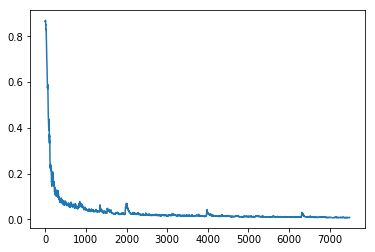

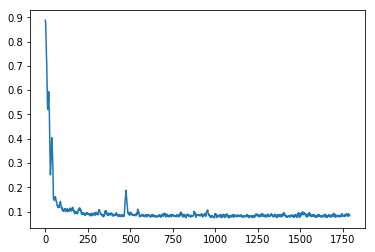

In [103]:

plt.plot(moving_average(np.flip(Ldc))); plt.show()
plt.plot(moving_average(np.flip(Lvdc))); plt.show()


In [38]:

my_dict={}
my_dict_val={}
valider(model)

('Epoch: ', 1, ' Batch: ', 1, ' Dice0: ', 0.002, ' Dice1: ', 0.527, ' CE: ', 0.023, ' Loss :', 0.287)
('Epoch: ', 1, ' Batch: ', 2, ' Dice0: ', 0.001, ' Dice1: ', 0.268, ' CE: ', 0.014, ' Loss :', 0.149)
('Epoch: ', 1, ' Batch: ', 3, ' Dice0: ', 0.001, ' Dice1: ', 0.181, ' CE: ', 0.01, ' Loss :', 0.101)
('Epoch: ', 1, ' Batch: ', 4, ' Dice0: ', 0.001, ' Dice1: ', 0.138, ' CE: ', 0.008, ' Loss :', 0.078)
('Epoch: ', 1, ' Batch: ', 5, ' Dice0: ', 0.001, ' Dice1: ', 0.112, ' CE: ', 0.007, ' Loss :', 0.064)
('Epoch: ', 1, ' Batch: ', 6, ' Dice0: ', 0.001, ' Dice1: ', 0.096, ' CE: ', 0.007, ' Loss :', 0.055)
('Epoch: ', 1, ' Batch: ', 7, ' Dice0: ', 0.001, ' Dice1: ', 0.083, ' CE: ', 0.006, ' Loss :', 0.048)
('Epoch: ', 1, ' Batch: ', 8, ' Dice0: ', 0.001, ' Dice1: ', 0.074, ' CE: ', 0.006, ' Loss :', 0.044)
('Epoch: ', 1, ' Batch: ', 9, ' Dice0: ', 0.001, ' Dice1: ', 0.067, ' CE: ', 0.006, ' Loss :', 0.04)
('Epoch: ', 1, ' Batch: ', 10, ' Dice0: ', 0.001, ' Dice1: ', 0.062, ' CE: ', 0.006,

('Epoch: ', 1, ' Batch: ', 92, ' Dice0: ', 0.001, ' Dice1: ', 0.028, ' CE: ', 0.005, ' Loss :', 0.019)
('Epoch: ', 1, ' Batch: ', 93, ' Dice0: ', 0.001, ' Dice1: ', 0.028, ' CE: ', 0.005, ' Loss :', 0.019)
('Epoch: ', 1, ' Batch: ', 94, ' Dice0: ', 0.001, ' Dice1: ', 0.028, ' CE: ', 0.005, ' Loss :', 0.019)
('Epoch: ', 1, ' Batch: ', 95, ' Dice0: ', 0.001, ' Dice1: ', 0.028, ' CE: ', 0.005, ' Loss :', 0.019)
('Epoch: ', 1, ' Batch: ', 96, ' Dice0: ', 0.001, ' Dice1: ', 0.028, ' CE: ', 0.005, ' Loss :', 0.019)
('Epoch: ', 1, ' Batch: ', 97, ' Dice0: ', 0.001, ' Dice1: ', 0.028, ' CE: ', 0.005, ' Loss :', 0.019)
('Epoch: ', 1, ' Batch: ', 98, ' Dice0: ', 0.001, ' Dice1: ', 0.028, ' CE: ', 0.005, ' Loss :', 0.019)
('Epoch: ', 1, ' Batch: ', 99, ' Dice0: ', 0.001, ' Dice1: ', 0.028, ' CE: ', 0.005, ' Loss :', 0.019)
('Epoch: ', 1, ' Batch: ', 100, ' Dice0: ', 0.001, ' Dice1: ', 0.028, ' CE: ', 0.005, ' Loss :', 0.019)
('Epoch: ', 1, ' Batch: ', 101, ' Dice0: ', 0.001, ' Dice1: ', 0.027, ' 

('Epoch: ', 1, ' Batch: ', 175, ' Dice0: ', 0.001, ' Dice1: ', 0.03, ' CE: ', 0.005, ' Loss :', 0.021)
('Epoch: ', 1, ' Batch: ', 176, ' Dice0: ', 0.001, ' Dice1: ', 0.03, ' CE: ', 0.005, ' Loss :', 0.02)
('Epoch: ', 1, ' Batch: ', 177, ' Dice0: ', 0.001, ' Dice1: ', 0.029, ' CE: ', 0.005, ' Loss :', 0.02)
('Epoch: ', 1, ' Batch: ', 178, ' Dice0: ', 0.001, ' Dice1: ', 0.029, ' CE: ', 0.005, ' Loss :', 0.02)
('Epoch: ', 1, ' Batch: ', 179, ' Dice0: ', 0.001, ' Dice1: ', 0.029, ' CE: ', 0.005, ' Loss :', 0.02)
('Epoch: ', 1, ' Batch: ', 180, ' Dice0: ', 0.001, ' Dice1: ', 0.029, ' CE: ', 0.005, ' Loss :', 0.02)
('Epoch: ', 1, ' Batch: ', 181, ' Dice0: ', 0.001, ' Dice1: ', 0.029, ' CE: ', 0.005, ' Loss :', 0.02)
('Epoch: ', 1, ' Batch: ', 182, ' Dice0: ', 0.001, ' Dice1: ', 0.029, ' CE: ', 0.005, ' Loss :', 0.02)
('Epoch: ', 1, ' Batch: ', 183, ' Dice0: ', 0.001, ' Dice1: ', 0.029, ' CE: ', 0.005, ' Loss :', 0.02)
('Epoch: ', 1, ' Batch: ', 184, ' Dice0: ', 0.001, ' Dice1: ', 0.029, ' CE

In [39]:
d1val=my_dict_val.copy()
d1t=my_dict.copy()

('Global Mean: ', 0.8513255640864372)
('Global Std: ', 0.14224262330683388)
('Epoch: ', -1, 'with ', 0, 'below')
('Clipped Mean: ', 0.9175143361091613)
('Number clipped: ', 13, 'of total ', 48)
Suspects: 
('P0211', [0.7566782832145691])
('P0212', [0.6784648299217224])
('P0098', [0.7741236090660095])
('P0071', [0.7985222935676575])
('P0084', [0.7416425943374634])
('P0194', [0.818117618560791])
('P0016', [0.6514126062393188])
('P0015', [0.29643094539642334])
('P0133', [0.684127151966095])
('P0056', [0.7391812801361084])
('P0225', [0.31926584243774414])
('P0243', [0.7887640595436096])
('P0054', [0.7038941979408264])
--
--
Min: 0.296
Q1: 0.813
Median: 0.888
Q3: 0.946
Max: 0.973


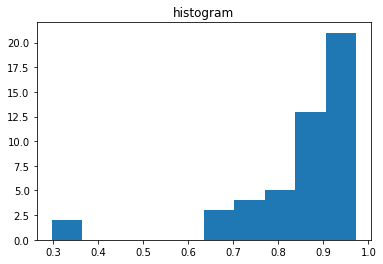

In [40]:
vals=val_stats(make_b(d1val),0.823)



('Global Mean: ', 0.9702909384018336)
('Global Std: ', 0.06416980594336603)
('Epoch: ', -1, 'with ', 0, 'below')
('Clipped Mean: ', 0.985588500728715)
('Number clipped: ', 18, 'of total ', 195)
Suspects: 
('P0199', [0.8616748452186584])
('P0213', [0.7984515428543091])
('P0152', [0.8631124496459961])
('P0151', [0.9049316644668579])
('P0086', [0.9251279830932617])
('P0196', [0.9277913570404053])
('P0073', [0.857597291469574])
('P0052', [0.92579185962677])
('P0181', [0.8874778151512146])
('P0198', [0.7296390533447266])
('P0013', [0.82680344581604])
('P0011', [0.9056262969970703])
('P0041', [0.7859539985656738])
('P0040', [0.812155544757843])
('P0042', [0.4590543508529663])
('P0100', [0.9240748882293701])
('P0031', [0.8889110684394836])
('P0226', [0.47339290380477905])
--
--
Min: 0.459
Q1: 0.978
Median: 0.989
Q3: 0.992
Max: 0.997


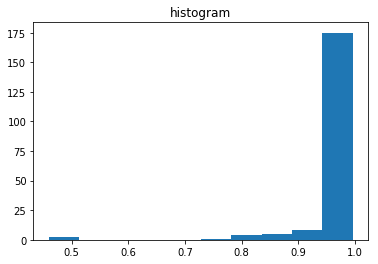

In [41]:
trans=val_stats(make_b(d1t),0.93)

In [29]:
vals

{'P0015': [0.2843683362007141],
 'P0016': [0.6552960872650146],
 'P0054': [0.7107717394828796],
 'P0056': [0.7637814283370972],
 'P0071': [0.7229576706886292],
 'P0084': [0.7520482540130615],
 'P0098': [0.7980660796165466],
 'P0133': [0.7154626846313477],
 'P0211': [0.7690579295158386],
 'P0212': [0.7093544006347656],
 'P0225': [0.3024343252182007],
 'P0243': [0.7872052788734436]}

In [30]:
#     Avg score of hard vals
c=[]
for e in vals:
    c.append(vals[e][0])
print(sum(c)/len(c))

#     Avg score of hard trains
c=[]
for e in trans:
    c.append(trans[e][0])
print(sum(c)/len(c))
    # higher val score indicates hard samples in val are using easier train features. Lets see if feats of hard help much for val

0.66423368454
0.819864908854


In [22]:
model.load_state_dict(torch.load('init_heart'))
# # 

('P0158', tensor(0.9481, device='cuda:0'))


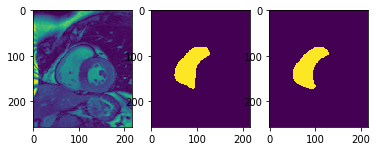

('P0071', tensor(0.7484, device='cuda:0'))


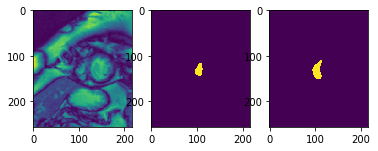

('P0227', tensor(0.9176, device='cuda:0'))


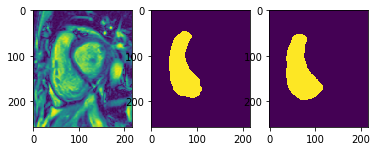

('P0054', tensor(0.7171, device='cuda:0'))


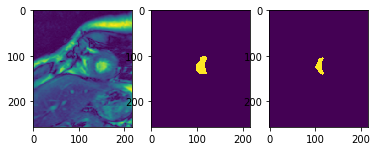

('P0235', tensor(0.8440, device='cuda:0'))


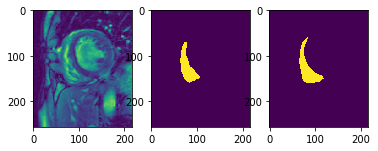

('P0038', tensor(0.8696, device='cuda:0'))


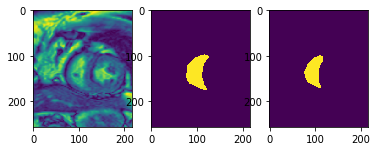

('P0039', tensor(0.7935, device='cuda:0'))


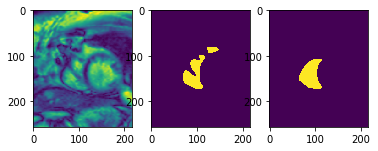

('P0233', tensor(0.9022, device='cuda:0'))


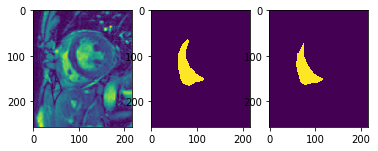

('P0215', tensor(0.9606, device='cuda:0'))


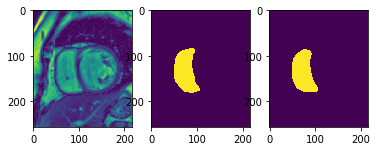

('P0097', tensor(0.8553, device='cuda:0'))


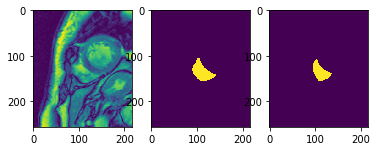

('P0084', tensor(0.5853, device='cuda:0'))


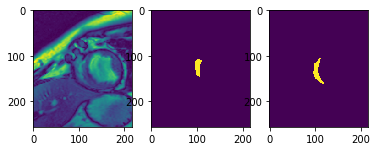

('P0120', tensor(0.9686, device='cuda:0'))


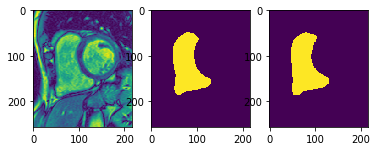

('P0122', tensor(0.9643, device='cuda:0'))


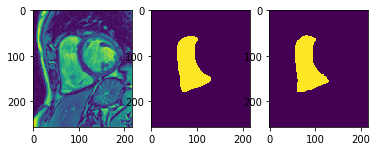

('P0002', tensor(0.8236, device='cuda:0'))


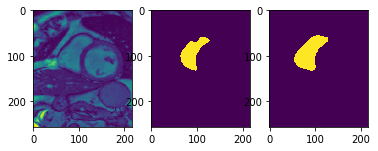

('P0056', tensor(0.7396, device='cuda:0'))


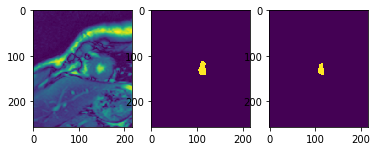

('P0016', tensor(0.0081, device='cuda:0'))


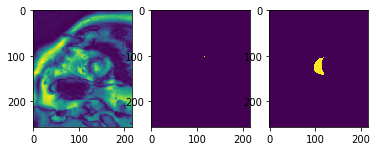

('P0240', tensor(0.7877, device='cuda:0'))


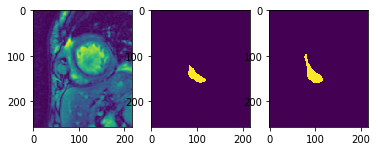

('P0208', tensor(0.9148, device='cuda:0'))


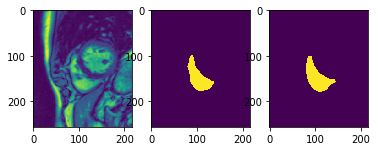

('P0143', tensor(0.9241, device='cuda:0'))


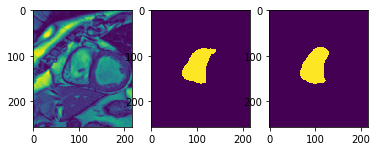

('P0021', tensor(0.9163, device='cuda:0'))


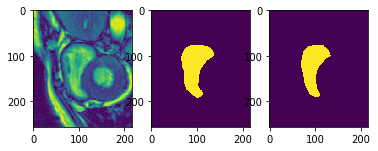

('P0003', tensor(0.0117, device='cuda:0'))


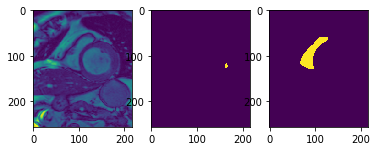

('P0140', tensor(0.8844, device='cuda:0'))


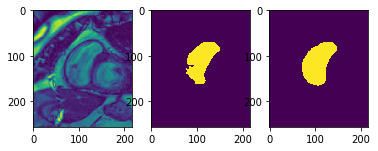

('P0137', tensor(0.6082, device='cuda:0'))


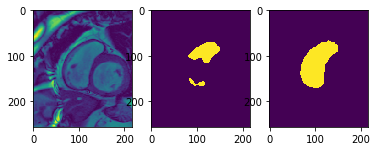

('P0017', tensor(0.9524, device='cuda:0'))


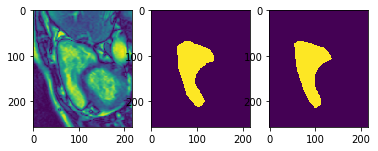

('P0051', tensor(0.9426, device='cuda:0'))


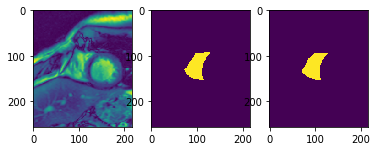

('P0163', tensor(0.9147, device='cuda:0'))


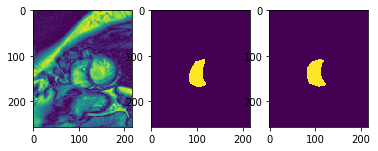

('P0160', tensor(0.9251, device='cuda:0'))


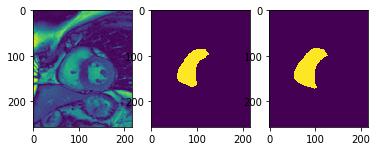

('P0192', tensor(0.8775, device='cuda:0'))


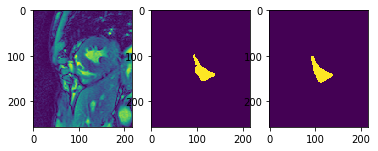

('P0156', tensor(0.9444, device='cuda:0'))


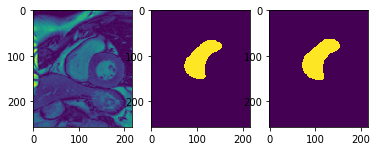

('P0210', tensor(0.9021, device='cuda:0'))


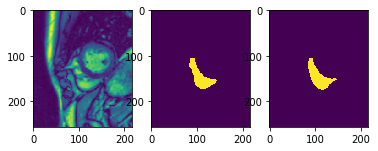

('P0173', tensor(0.9150, device='cuda:0'))


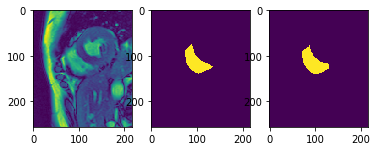

('P0015', tensor(0.0002, device='cuda:0'))


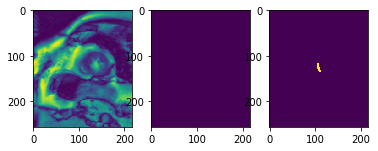

('P0169', tensor(0.8953, device='cuda:0'))


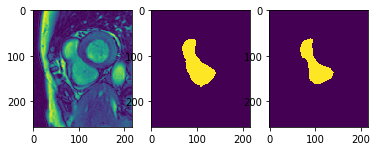

('P0109', tensor(0.9112, device='cuda:0'))


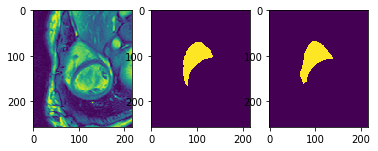

('P0133', tensor(0.7276, device='cuda:0'))


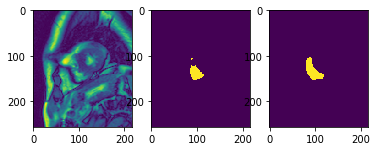

('P0076', tensor(0.8666, device='cuda:0'))


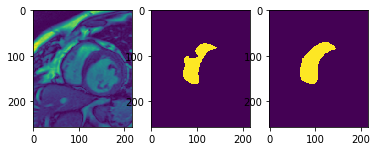

('P0194', tensor(0.8422, device='cuda:0'))


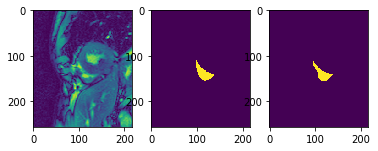

('P0243', tensor(0.8037, device='cuda:0'))


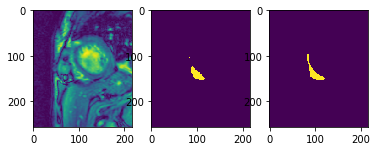

('P0197', tensor(0.7718, device='cuda:0'))


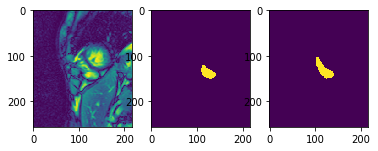

('P0098', tensor(0.7547, device='cuda:0'))


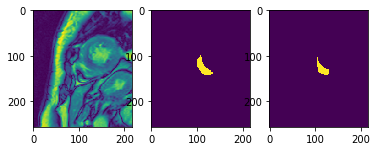

('P0131', tensor(0.8501, device='cuda:0'))


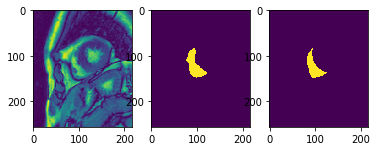

('P0070', tensor(0.9117, device='cuda:0'))


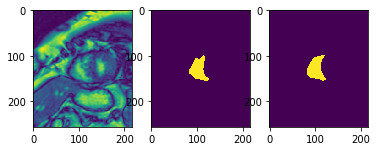

('P0225', tensor(0.4140, device='cuda:0'))


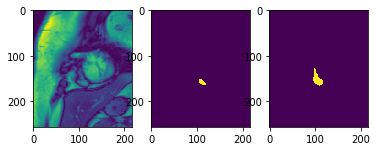

('P0023', tensor(0.9038, device='cuda:0'))


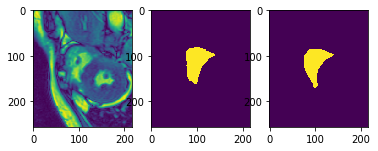

('P0125', tensor(0.9291, device='cuda:0'))


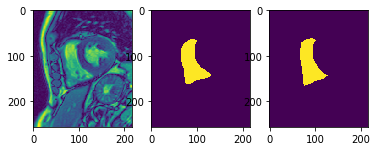

('P0211', tensor(0.7868, device='cuda:0'))


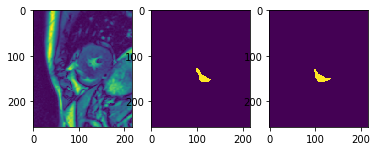

('P0212', tensor(0.7834, device='cuda:0'))


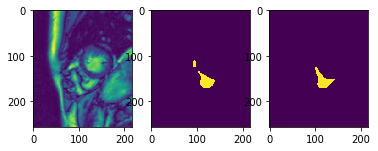

('P0164', tensor(0.8788, device='cuda:0'))


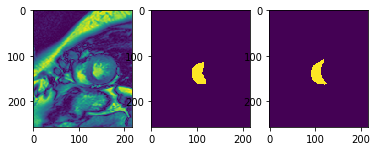

In [70]:
val_vis=DataLoader(dataset_val,1,shuffle=True, num_workers=2) 

with torch.set_grad_enabled(False):    
    for idx, batch_data in enumerate(val_vis):

        name=batch_data['name']
        input = Variable(batch_data['image'].float()).cuda()#.to(device)
        dice_mask = Variable(batch_data['mask'].float()).cuda()
        ce_tar=Variable(batch_data['mask2']).cuda()

        pred_mask = model(input)

        ce = loss_fn(pred_mask, ce_tar.long())
        soft_mask=soft_max(pred_mask)
    #                 dice=dice_loss_classes(soft_mask, batch_gt_mask)

        a,b=dice_loss_classes(soft_mask, dice_mask)

        plt.subplot(1,3,1)
        plt.imshow(input[0].transpose(0,1).transpose(2,1).cpu().detach()[:,:,0] )

        arg=torch.argmax(soft_mask,1)
        plt.subplot(1,3,2)
        plt.imshow(arg[0].cpu().detach())
        plt.subplot(1,3,3)
        print(name[0],1-b)
        plt.imshow(ce_tar[0].cpu().detach())
        plt.show()

#                 print('Dice Losses: ',a.item(),b.item())
                
                